In [1]:
# import torch
import numpy as np
import matplotlib.pyplot as plt
# import torch.nn.functional as F
# from torch.utils.data import Dataset
# from google.colab import drive 
import math
# from torch.utils.data import DataLoader
import pandas as pd
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Input
import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import LSTM, Dropout, Flatten
# from tensorflow.keras_self_attention import SeqSelfAttention
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [3]:
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

### Problem Description 
- Given a set of N related univeriate time series $\{z_{i,1:t_0}\}_{i=1}^{N}$, where $z_{i,1:t_0} \overset{\Delta}{=}[z_{i,1},z_{i,2},...,z_{i,t_0}]$ and $z_{i,t} \in \mathcal{R}$
- The objectif is to predict the next $\tau $ for all time series $\{z_{i,t_0+1:t_0+\tau}\}_{i=1}^{N}$
- The paper introduce a simple one-step-ahead prediction model $p(z_t|z_{i,1:t-1}, x_{i,1:t}; \Phi)$, which is derived from modeling the conditional probality $p(z_{i,t_0+1:t_0+ \tau}|z_{i,1:t_0}, x_{i,1:t_0+\tau};\Phi) = \prod_{t=t_0+1}^{t_0+\tau} p(z_{i,t}|z_{i,1:t -1}, x_{i,1:t};\Phi)$


## Experiment description 
In this experimental setting two dataset have been used, namely the gold price dataset and the mineral dataset [ Description will be provide ] 
The first dataset is use to outline the univariate time series forcasting and the second dataset is used for the multivariate forecasting scenario. The experiment aims to analyse the effectivness of different deep leanring architecture in the forecasting problem. 
The experiment is composed of : 


1.   The performance evaluation of RNN, CNN, DNN, SARIMX in univariate and multivariate forecasting 
2.   The effect of adding more hidden layers
3.   The effect of regularization 



In [4]:

filepath = 'CMO-Historical-Data-Monthly.xlsx'
xls = pd.ExcelFile(filepath)

In [60]:
columns = ['PHOSROCK', 'DAP', 'TSP', 'UREA_EE_BULK', 'POTASH',	'ALUMINUM', 'IRON_ORE',	'COPPER', 'LEAD', 'Tin', 'NICKEL',	'Zinc', 'GOLD', 'PLATINUM',	'SILVER']

In [78]:
df1 = pd.read_excel(xls, sheet_name='Monthly Prices',usecols=[ i for i in range(57,72)],  skiprows=6, names=columns) # skiprows: skip the title page 
# data  df1.copy()#['time', 'data'] # set a columns names  df1[[3,4]]
df1

,PHOSROCK,DAP,TSP,UREA_EE_BULK,POTASH,ALUMINUM,IRON_ORE,COPPER,LEAD,Tin,NICKEL,Zinc,GOLD,PLATINUM,SILVER
0,13.0,..,53.00,42.25,28.5,511.471832,11.42,715.40,206.10,2180.40,1631.00,260.80,35.27,83.50,0.9137
1,13.0,..,53.00,42.25,28.5,511.471832,11.42,728.19,203.70,2180.40,1631.00,244.90,35.27,83.50,0.9137
2,13.0,..,53.00,42.25,28.5,511.471832,11.42,684.94,210.30,2173.80,1631.00,248.70,35.27,83.50,0.9137
3,13.0,..,53.00,42.25,28.5,511.471832,11.42,723.11,213.60,2178.20,1631.00,254.60,35.27,83.50,0.9137
4,13.0,..,53.00,42.25,28.5,511.471832,11.42,684.75,213.40,2162.70,1631.00,253.80,35.27,83.50,0.9137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,320.0,784,736.00,601.00,562.5,2408.420000,108.57,7544.81,1985.20,25395.77,21481.89,3105.36,1732.74,869.25,19.0750
751,320.0,749.38,703.75,591.25,562.5,2430.790000,108.85,7981.84,2072.72,24647.48,22057.39,3587.57,1764.56,908.65,19.7240
752,320.0,752,708.00,678.00,562.5,2224.760000,99.81,7746.01,1870.10,21124.04,22773.97,3124.97,1680.78,881.24,18.9440
753,317.5,725,675.00,636.25,562.5,2255.540000,92.56,7651.08,1999.86,19391.17,22032.89,2967.21,1664.45,914.67,19.4260


In [85]:
df1.head()

,PHOSROCK,DAP,TSP,UREA_EE_BULK,POTASH,ALUMINUM,IRON_ORE,COPPER,LEAD,Tin,NICKEL,Zinc,GOLD,PLATINUM,SILVER
1960M01,13.0,..,53.0,42.25,28.5,511.471832,11.42,715.40,206.1,2180.4,1631.0,260.8,35.27,83.5,0.9137
1960M02,13.0,..,53.0,42.25,28.5,511.471832,11.42,728.19,203.7,2180.4,1631.0,244.9,35.27,83.5,0.9137
1960M03,13.0,..,53.0,42.25,28.5,511.471832,11.42,684.94,210.3,2173.8,1631.0,248.7,35.27,83.5,0.9137
1960M04,13.0,..,53.0,42.25,28.5,511.471832,11.42,723.11,213.6,2178.2,1631.0,254.6,35.27,83.5,0.9137
1960M05,13.0,..,53.0,42.25,28.5,511.471832,11.42,684.75,213.4,2162.7,1631.0,253.8,35.27,83.5,0.9137


In [82]:
df1.index = index_list

In [81]:
index_list

['1960M01',
 '1960M02',
 '1960M03',
 '1960M04',
 '1960M05',
 '1960M06',
 '1960M07',
 '1960M08',
 '1960M09',
 '1960M10',
 '1960M11',
 '1960M12',
 '1961M01',
 '1961M02',
 '1961M03',
 '1961M04',
 '1961M05',
 '1961M06',
 '1961M07',
 '1961M08',
 '1961M09',
 '1961M10',
 '1961M11',
 '1961M12',
 '1962M01',
 '1962M02',
 '1962M03',
 '1962M04',
 '1962M05',
 '1962M06',
 '1962M07',
 '1962M08',
 '1962M09',
 '1962M10',
 '1962M11',
 '1962M12',
 '1963M01',
 '1963M02',
 '1963M03',
 '1963M04',
 '1963M05',
 '1963M06',
 '1963M07',
 '1963M08',
 '1963M09',
 '1963M10',
 '1963M11',
 '1963M12',
 '1964M01',
 '1964M02',
 '1964M03',
 '1964M04',
 '1964M05',
 '1964M06',
 '1964M07',
 '1964M08',
 '1964M09',
 '1964M10',
 '1964M11',
 '1964M12',
 '1965M01',
 '1965M02',
 '1965M03',
 '1965M04',
 '1965M05',
 '1965M06',
 '1965M07',
 '1965M08',
 '1965M09',
 '1965M10',
 '1965M11',
 '1965M12',
 '1966M01',
 '1966M02',
 '1966M03',
 '1966M04',
 '1966M05',
 '1966M06',
 '1966M07',
 '1966M08',
 '1966M09',
 '1966M10',
 '1966M11',
 '19

In [70]:
df1.index = data.index

In [71]:
df1

,PHOSROCK,DAP,TSP,UREA_EE_BULK,POTASH,ALUMINUM,IRON_ORE,COPPER,LEAD,Tin,NICKEL,Zinc,GOLD,PLATINUM,SILVER
0,13.0,..,53.00,42.25,28.5,511.471832,11.42,715.40,206.10,2180.40,1631.00,260.80,35.27,83.50,0.9137
1,13.0,..,53.00,42.25,28.5,511.471832,11.42,728.19,203.70,2180.40,1631.00,244.90,35.27,83.50,0.9137
2,13.0,..,53.00,42.25,28.5,511.471832,11.42,684.94,210.30,2173.80,1631.00,248.70,35.27,83.50,0.9137
3,13.0,..,53.00,42.25,28.5,511.471832,11.42,723.11,213.60,2178.20,1631.00,254.60,35.27,83.50,0.9137
4,13.0,..,53.00,42.25,28.5,511.471832,11.42,684.75,213.40,2162.70,1631.00,253.80,35.27,83.50,0.9137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,320.0,784,736.00,601.00,562.5,2408.420000,108.57,7544.81,1985.20,25395.77,21481.89,3105.36,1732.74,869.25,19.0750
751,320.0,749.38,703.75,591.25,562.5,2430.790000,108.85,7981.84,2072.72,24647.48,22057.39,3587.57,1764.56,908.65,19.7240
752,320.0,752,708.00,678.00,562.5,2224.760000,99.81,7746.01,1870.10,21124.04,22773.97,3124.97,1680.78,881.24,18.9440
753,317.5,725,675.00,636.25,562.5,2255.540000,92.56,7651.08,1999.86,19391.17,22032.89,2967.21,1664.45,914.67,19.4260


In [76]:
data.set_index()

,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
0,,,,,,,,,,,,,,,,,,,,,
1960M01,1.630000,1.63,1.63,…,…,…,0.1400,0.404774,…,…,...,511.471832,11.42,715.40,206.10,2180.40,1631.00,260.80,35.27,83.50,0.9137
1960M02,1.630000,1.63,1.63,…,…,…,0.1400,0.404774,…,…,...,511.471832,11.42,728.19,203.70,2180.40,1631.00,244.90,35.27,83.50,0.9137
1960M03,1.630000,1.63,1.63,…,…,…,0.1400,0.404774,…,…,...,511.471832,11.42,684.94,210.30,2173.80,1631.00,248.70,35.27,83.50,0.9137
1960M04,1.630000,1.63,1.63,…,…,…,0.1400,0.404774,…,…,...,511.471832,11.42,723.11,213.60,2178.20,1631.00,254.60,35.27,83.50,0.9137
1960M05,1.630000,1.63,1.63,…,…,…,0.1400,0.404774,…,…,...,511.471832,11.42,684.75,213.40,2162.70,1631.00,253.80,35.27,83.50,0.9137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022M07,105.083333,108.92,106.48,99.85,402.2,329.818,7.2561,51.330030,18.8808,344.927,...,2408.420000,108.57,7544.81,1985.20,25395.77,21481.89,3105.36,1732.74,869.25,19.0750
2022M08,95.973333,98.60,97.75,91.57,406.97,318.276,8.7854,70.043640,21.2108,454.04,...,2430.790000,108.85,7981.84,2072.72,24647.48,22057.39,3587.57,1764.56,908.65,19.7240
2022M09,88.220000,90.16,90.63,83.87,430.81,321.476,7.7629,59.102622,23.7338,391.32,...,2224.760000,99.81,7746.01,1870.10,21124.04,22773.97,3124.97,1680.78,881.24,18.9440


In [77]:
data.index

RangeIndex(start=0, stop=755, step=1)

In [51]:
len(columns), df1.shape

(14, (756, 15))

In [39]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1960M01,1.63,1.63,1.63,…,…,…,0.14,0.404774,…,...,511.471832,11.42,715.40,206.1,2180.4,1631.0,260.8,35.27,83.5,0.9137
1,1960M02,1.63,1.63,1.63,…,…,…,0.14,0.404774,…,...,511.471832,11.42,728.19,203.7,2180.4,1631.0,244.9,35.27,83.5,0.9137
2,1960M03,1.63,1.63,1.63,…,…,…,0.14,0.404774,…,...,511.471832,11.42,684.94,210.3,2173.8,1631.0,248.7,35.27,83.5,0.9137
3,1960M04,1.63,1.63,1.63,…,…,…,0.14,0.404774,…,...,511.471832,11.42,723.11,213.6,2178.2,1631.0,254.6,35.27,83.5,0.9137
4,1960M05,1.63,1.63,1.63,…,…,…,0.14,0.404774,…,...,511.471832,11.42,684.75,213.4,2162.7,1631.0,253.8,35.27,83.5,0.9137


In [25]:
data.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71],
           dtype='int64')

In [38]:
data.shape

(755, 72)

In [36]:
data.shape

(755, 15)

In [9]:
data.columns = ['date','USD' ,	'EUR' ,	'JPY' ,	'GBP' ,	'CAD' ,	'CHF' ,	'INR' ,	'CNY' ,	'USD' ,	'TRY' ,	'SAR' ,	'IDR' ,	'AED' ,	'THB' ,	'VND' ,	'EGP' ,	'KRW' ,	'EUR' ,	'RUB' ,	'USD' ,	'ZAR' ,	'CNY' ,	'CAD' ,	'AUD']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11090 entries, 0 to 11089
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11090 non-null  datetime64[ns]
 1   USD     11090 non-null  float64       
 2   EUR     11090 non-null  float64       
 3   JPY     11089 non-null  float64       
 4   GBP     11090 non-null  float64       
 5   CAD     11089 non-null  float64       
 6   CHF     11089 non-null  float64       
 7   INR     11089 non-null  float64       
 8   CNY     9520 non-null   float64       
 9   USD     11090 non-null  float64       
 10  TRY     10046 non-null  float64       
 11  SAR     11089 non-null  float64       
 12  IDR     11089 non-null  float64       
 13  AED     11089 non-null  float64       
 14  THB     11089 non-null  float64       
 15  VND     8240 non-null   float64       
 16  EGP     8500 non-null   float64       
 17  KRW     11089 non-null  float64       
 18  EUR   

## We can observe that the [CNY, VND, EGP, RUB] have large number of missing values and duplicates 
Possible soltutions:


*   Drop the columns 
*   Interpolate the the missing using linear interpolation 

I will drop these columns 



In [10]:
d_data = data.T.drop_duplicates().T

In [11]:
d_data.columns

Index(['date', 'USD', 'EUR', 'JPY', 'GBP', 'CAD', 'CHF', 'INR', 'CNY', 'TRY',
       'SAR', 'IDR', 'AED', 'THB', 'VND', 'EGP', 'KRW', 'RUB', 'ZAR', 'AUD'],
      dtype='object')

In [12]:
d_data.drop(labels=['CNY', 'VND', 'EGP', 'RUB'],axis=1, inplace=True)

In [13]:
d_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11090 entries, 0 to 11089
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11090 non-null  datetime64[ns]
 1   USD     11090 non-null  object        
 2   EUR     11090 non-null  object        
 3   JPY     11089 non-null  object        
 4   GBP     11090 non-null  object        
 5   CAD     11089 non-null  object        
 6   CHF     11089 non-null  object        
 7   INR     11089 non-null  object        
 8   TRY     10046 non-null  object        
 9   SAR     11089 non-null  object        
 10  IDR     11089 non-null  object        
 11  AED     11089 non-null  object        
 12  THB     11089 non-null  object        
 13  KRW     11089 non-null  object        
 14  ZAR     11089 non-null  object        
 15  AUD     11089 non-null  object        
dtypes: datetime64[ns](1), object(15)
memory usage: 1.4+ MB


Let's count the number of missing values per columns 

In [14]:
d_data.isna().sum()

date       0
USD        0
EUR        0
JPY        1
GBP        0
CAD        1
CHF        1
INR        1
TRY     1044
SAR        1
IDR        1
AED        1
THB        1
KRW        1
ZAR        1
AUD        1
dtype: int64

In [15]:
d_data.drop('TRY', axis = 1, inplace=True)

## One can observe that one missing value is present in most the columns, so they can be droped 

In [16]:
d_data.dropna(inplace=True)
d_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11089 entries, 1 to 11089
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11089 non-null  datetime64[ns]
 1   USD     11089 non-null  object        
 2   EUR     11089 non-null  object        
 3   JPY     11089 non-null  object        
 4   GBP     11089 non-null  object        
 5   CAD     11089 non-null  object        
 6   CHF     11089 non-null  object        
 7   INR     11089 non-null  object        
 8   SAR     11089 non-null  object        
 9   IDR     11089 non-null  object        
 10  AED     11089 non-null  object        
 11  THB     11089 non-null  object        
 12  KRW     11089 non-null  object        
 13  ZAR     11089 non-null  object        
 14  AUD     11089 non-null  object        
dtypes: datetime64[ns](1), object(14)
memory usage: 1.4+ MB


In [17]:
d_data = d_data.set_index(['date'])
d_data = d_data.astype('float32')

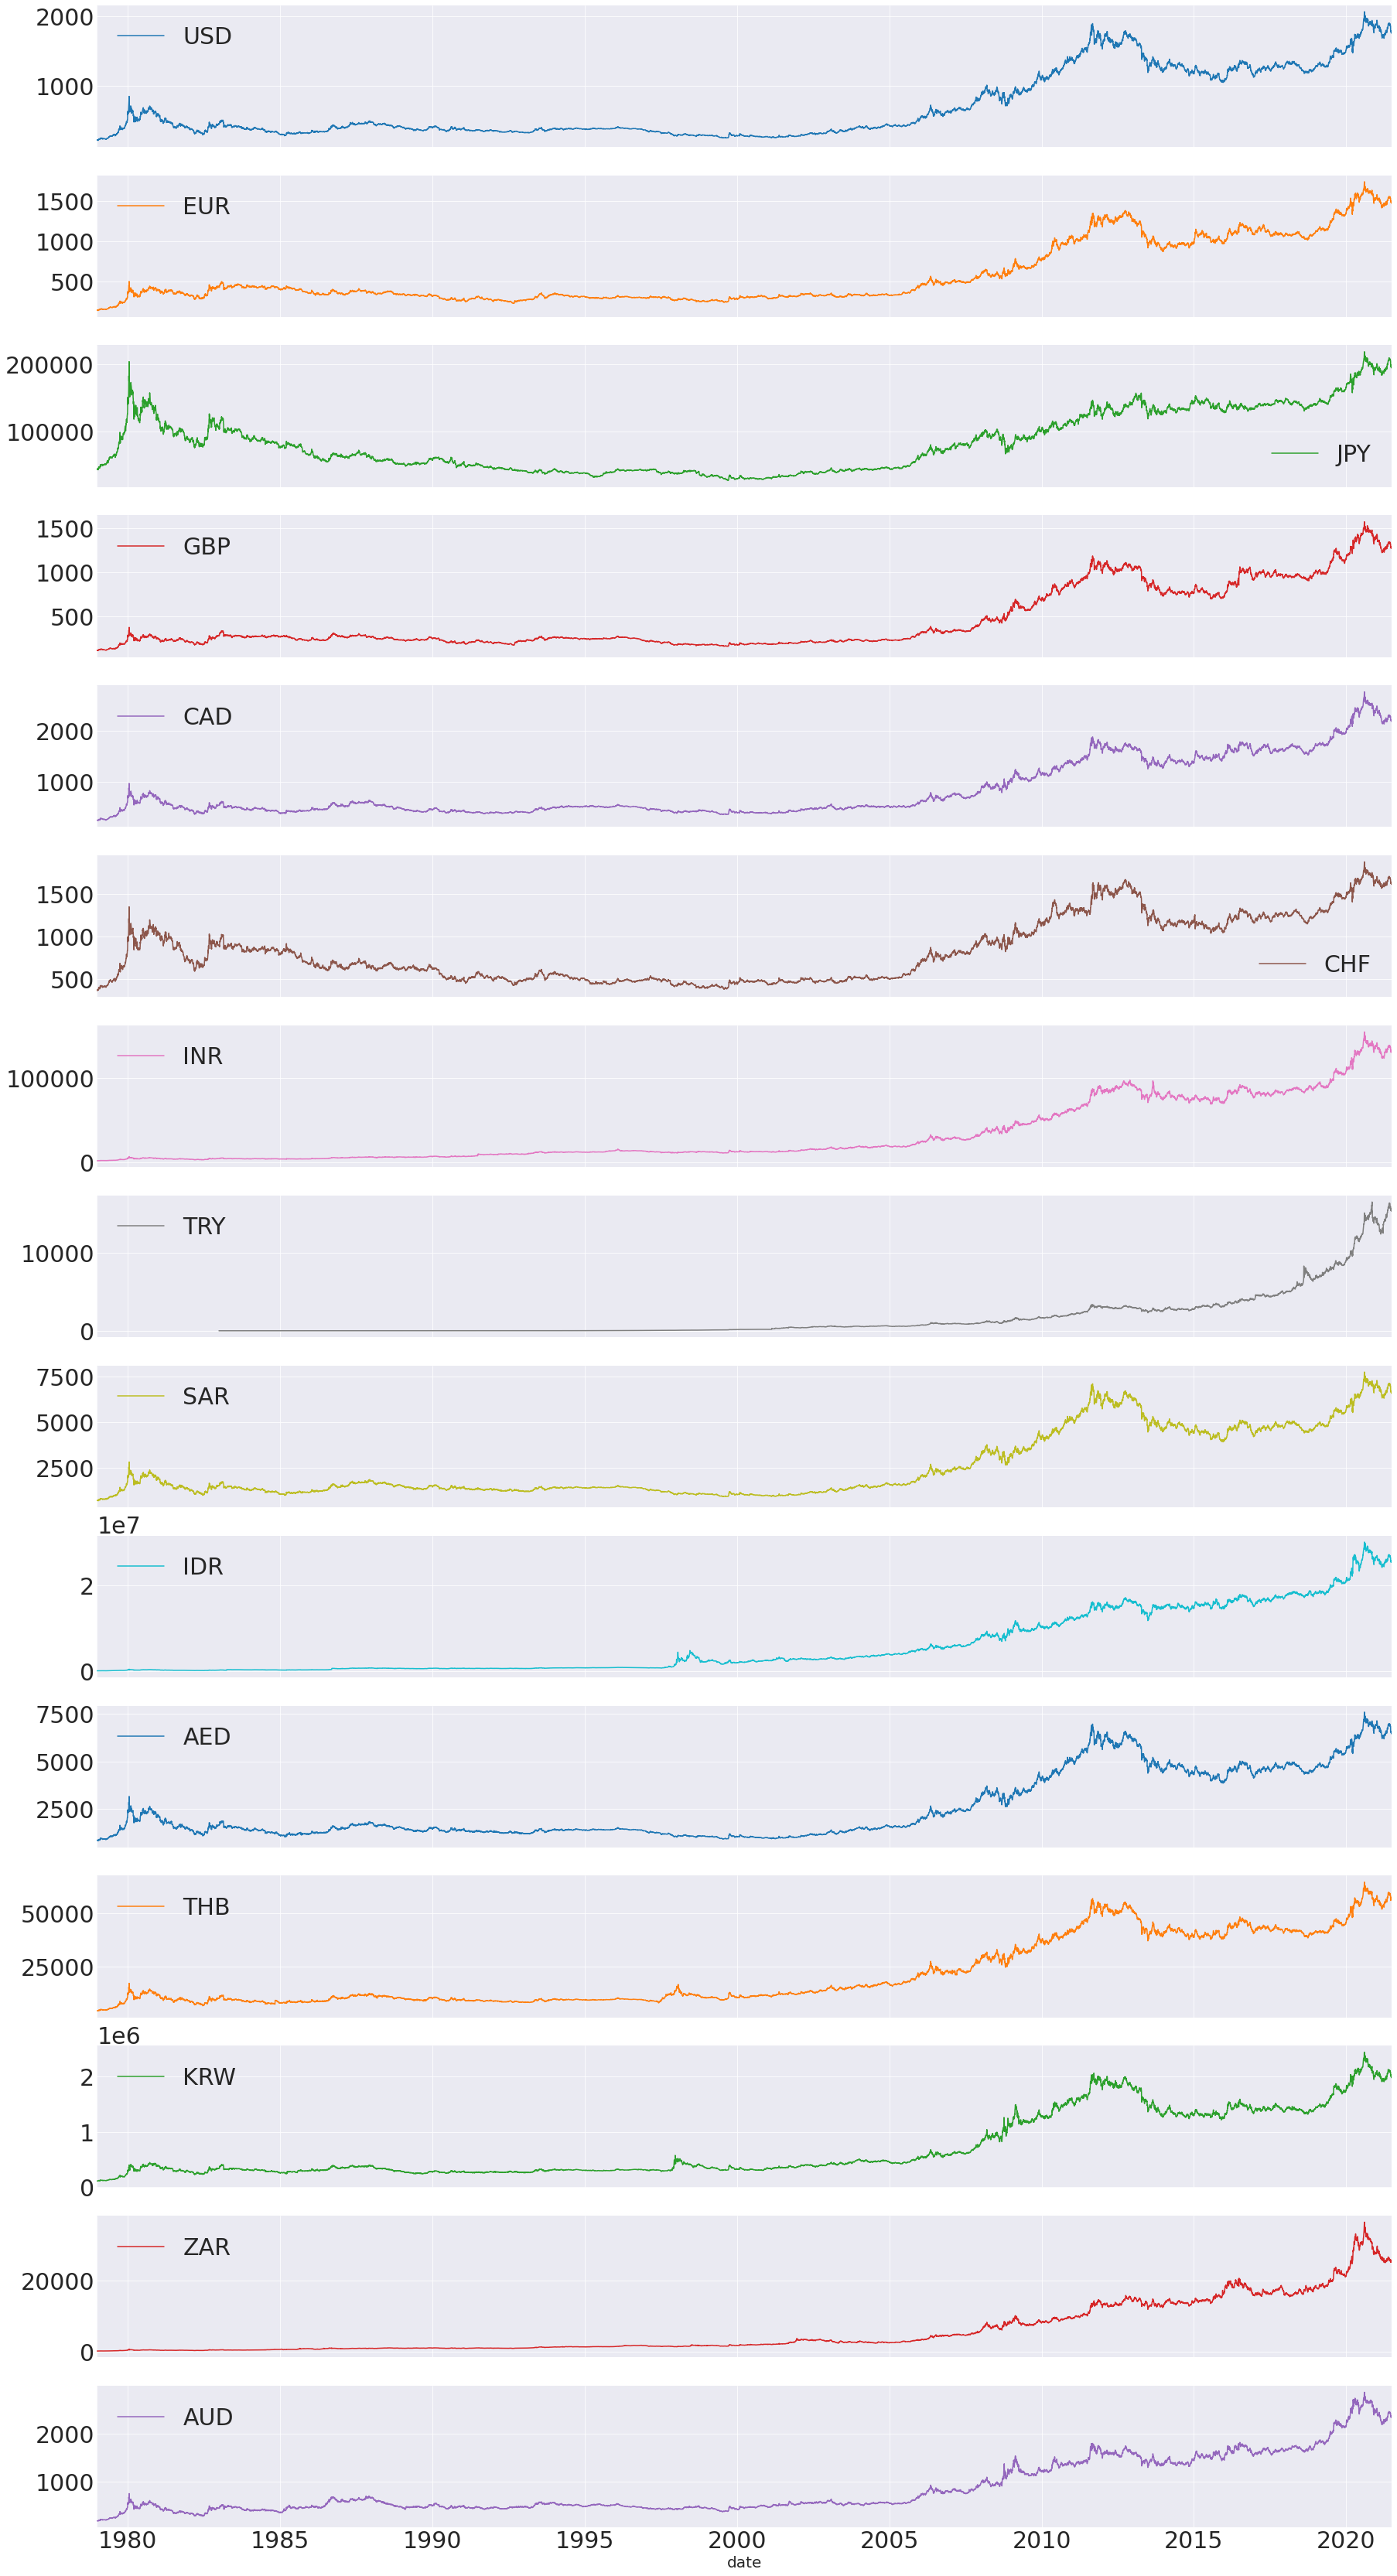

In [ ]:
SMALL_SIZE = 30
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
with plt.style.context('seaborn-darkgrid'):
  d_data.plot(subplots=True, figsize=(30,60))

In [57]:
d_data.index

DatetimeIndex(['1979-01-02', '1979-01-03', '1979-01-04', '1979-01-05',
               '1979-01-08', '1979-01-09', '1979-01-10', '1979-01-11',
               '1979-01-12', '1979-01-15',
               ...
               '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
               '2021-06-25', '2021-06-28', '2021-06-29', '2021-06-30',
               '2021-07-01', '2021-07-02'],
              dtype='datetime64[ns]', name='date', length=11089, freq=None)

In [61]:
d_data.index.month

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            6, 6, 6, 6, 6, 6, 6, 6, 7, 7],
           dtype='int64', name='date', length=11089)

In [60]:
d_data.index.year

Int64Index([1979, 1979, 1979, 1979, 1979, 1979, 1979, 1979, 1979, 1979,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='date', length=11089)

In [59]:
d_data.index.weekday

Int64Index([1, 2, 3, 4, 0, 1, 2, 3, 4, 0,
            ...
            0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
           dtype='int64', name='date', length=11089)

In [58]:
d_data.index.dayofweek

Int64Index([1, 2, 3, 4, 0, 1, 2, 3, 4, 0,
            ...
            0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
           dtype='int64', name='date', length=11089)

In [62]:
d_data['days'] = d_data.index.dayofweek
d_data['month'] = d_data.index.month
d_data['year'] = d_data.index.year

In [ ]:
d_data.index

DatetimeIndex(['1979-01-02', '1979-01-03', '1979-01-04', '1979-01-05',
               '1979-01-08', '1979-01-09', '1979-01-10', '1979-01-11',
               '1979-01-12', '1979-01-15',
               ...
               '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
               '2021-06-25', '2021-06-28', '2021-06-29', '2021-06-30',
               '2021-07-01', '2021-07-02'],
              dtype='datetime64[ns]', name='date', length=11089, freq=None)

In [ ]:
titles = [f'gold price in {a}' for a in d_data.columns]

In [ ]:
len(titles)

15

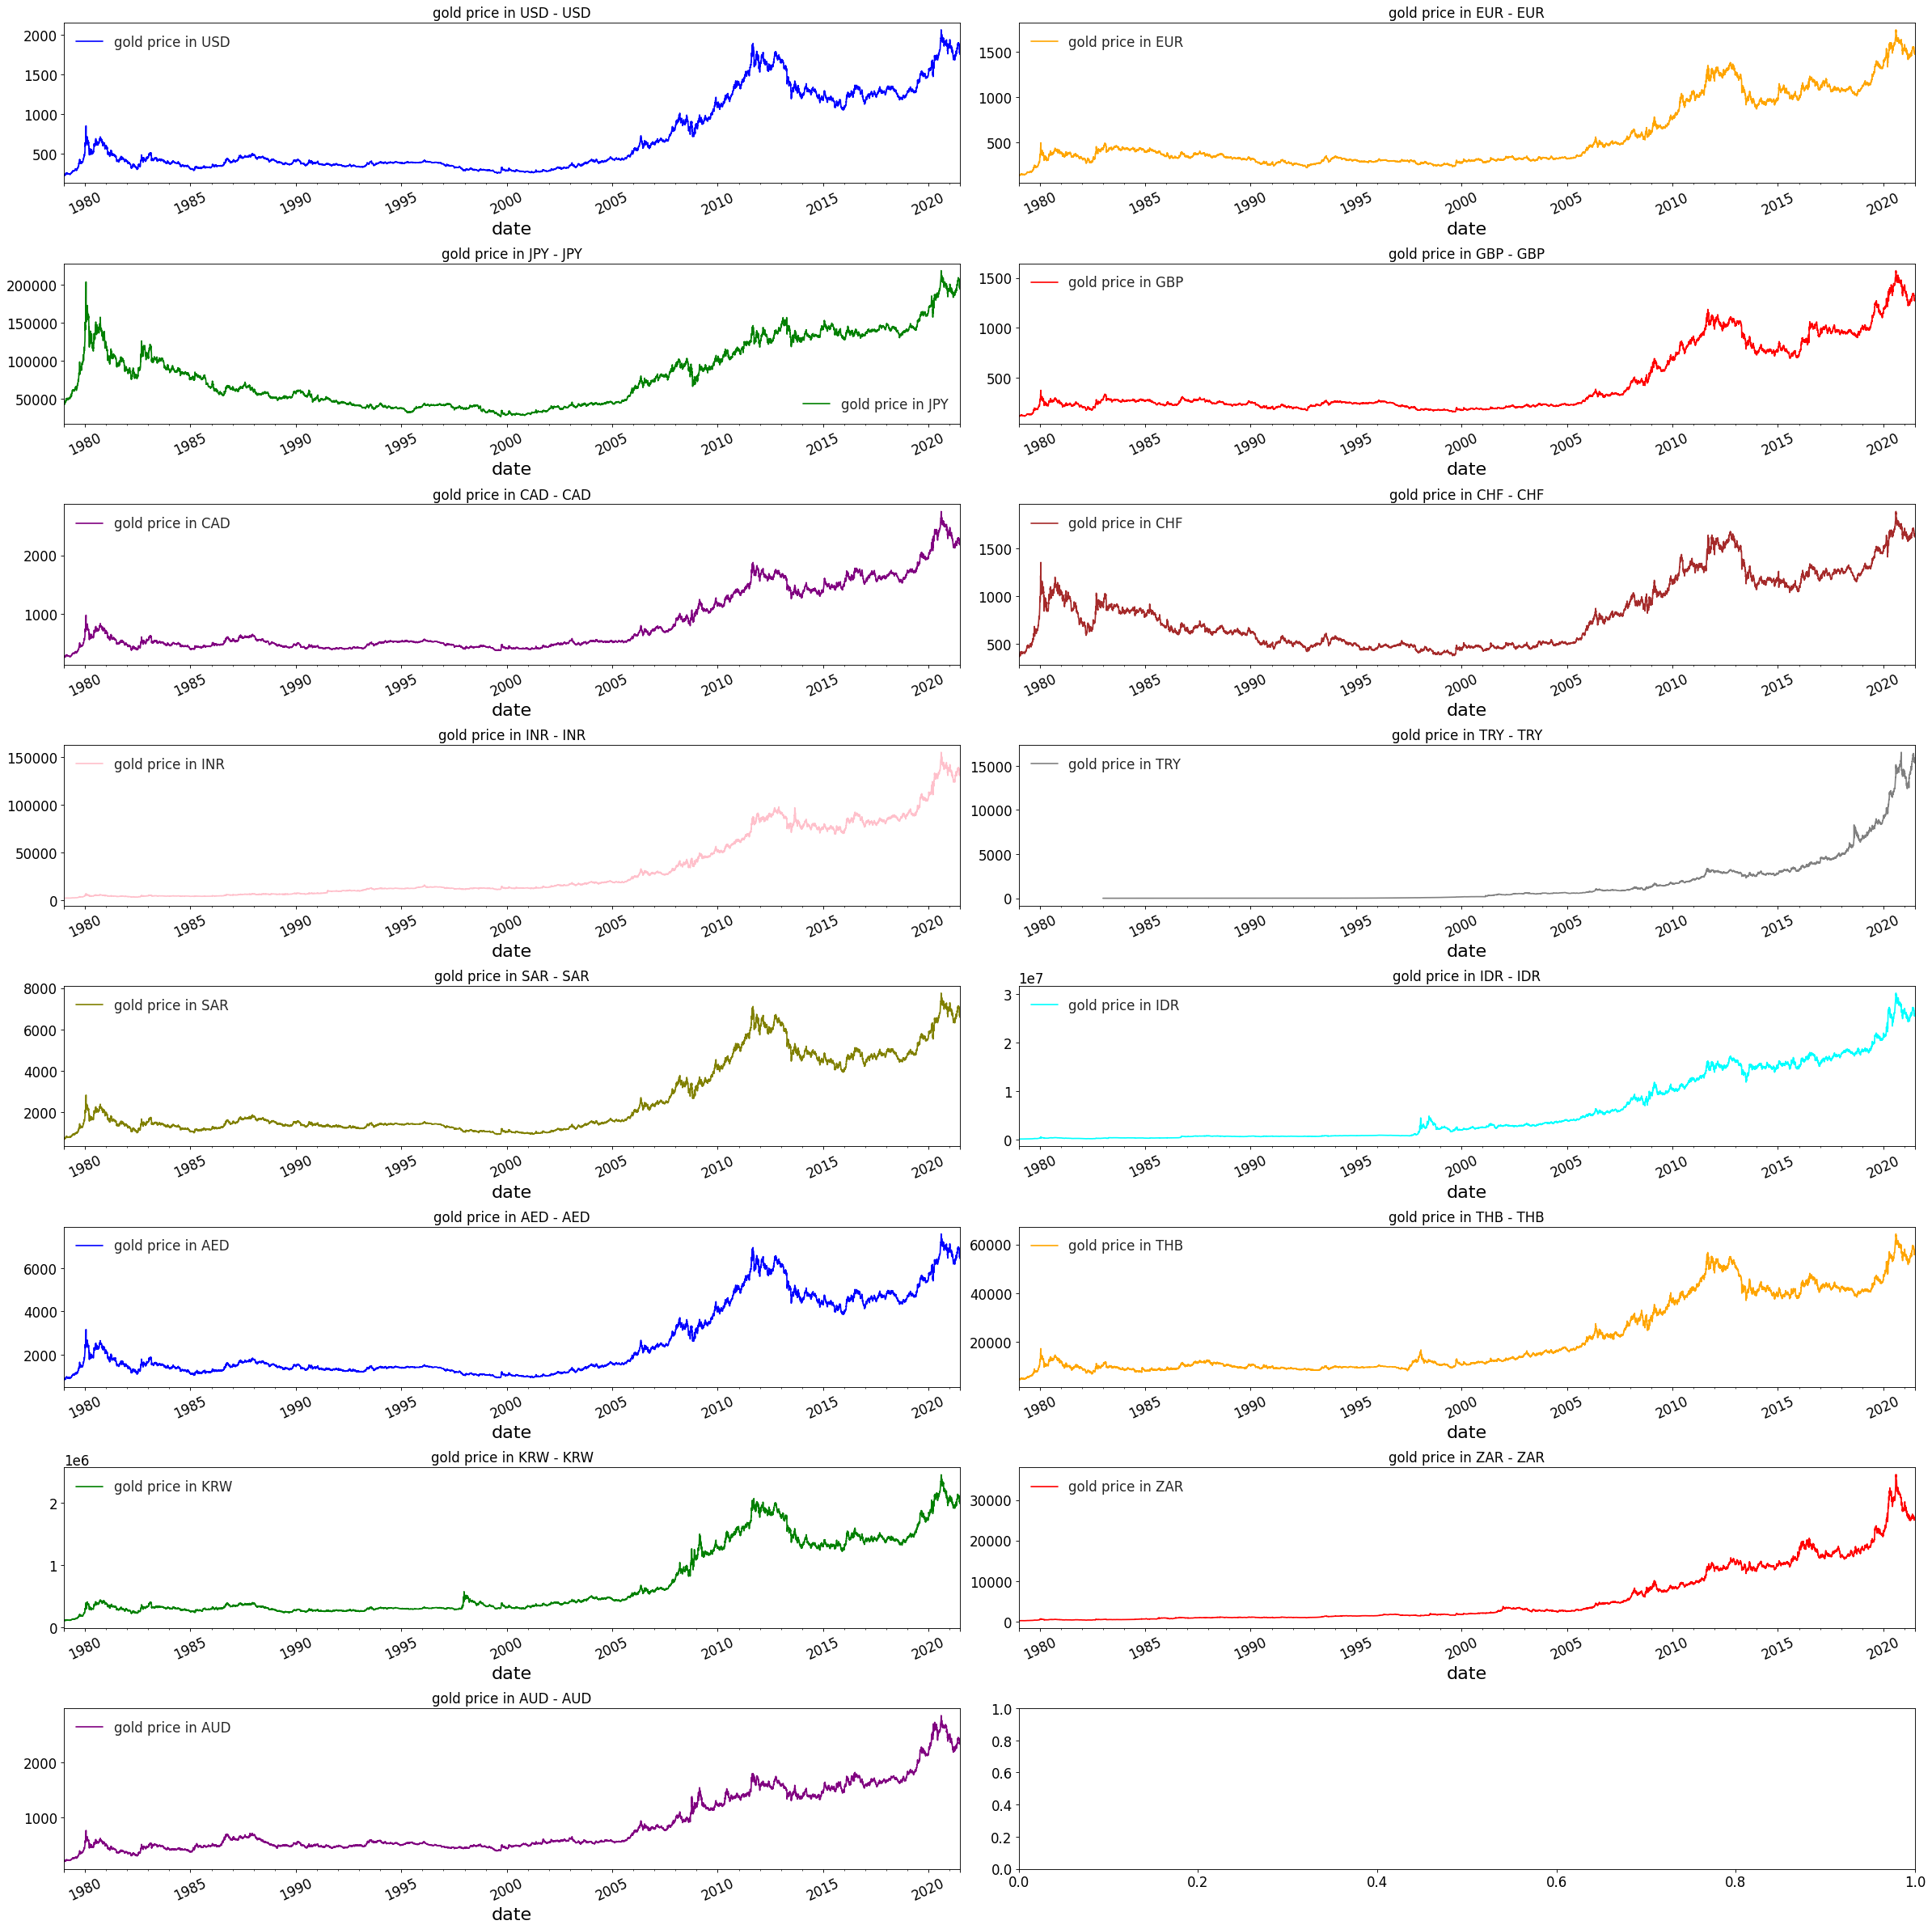

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, dpi=600)  # fontsize of the figure title
titles = [f'gold price in {a}' for a in d_data.columns]

feature_keys = [ a for a in d_data.columns]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
date_time_key = "Date Time"


def show_raw_visualization(data):
    # time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=int(data.shape[1] /2 )+1, ncols=2, figsize=(30, 30), dpi=80, facecolor="w", edgecolor="k"
    )
    with plt.style.context('seaborn-dark'):
      # Set default figure size
      # fig.figsize : 3.3, 2.5
      # fig.dpi : 600

      # # Font sizes
      # font.size : 8
      # font.family : serif
      # font.serif : Times
      for i in range(len(feature_keys)):
          key = feature_keys[i]
          c = colors[i % (len(colors))]
          t_data = data[key]
          t_data.index = data.index
          t_data.head()
          ax = t_data.plot(
              ax=axes[i // 2, i % 2],
              color=c,
              title="{} - {}".format(titles[i], key),
              rot=25,
          )
          ax.legend([titles[i]])
      plt.tight_layout()


show_raw_visualization(d_data)

# Univarariate time series forecasting 

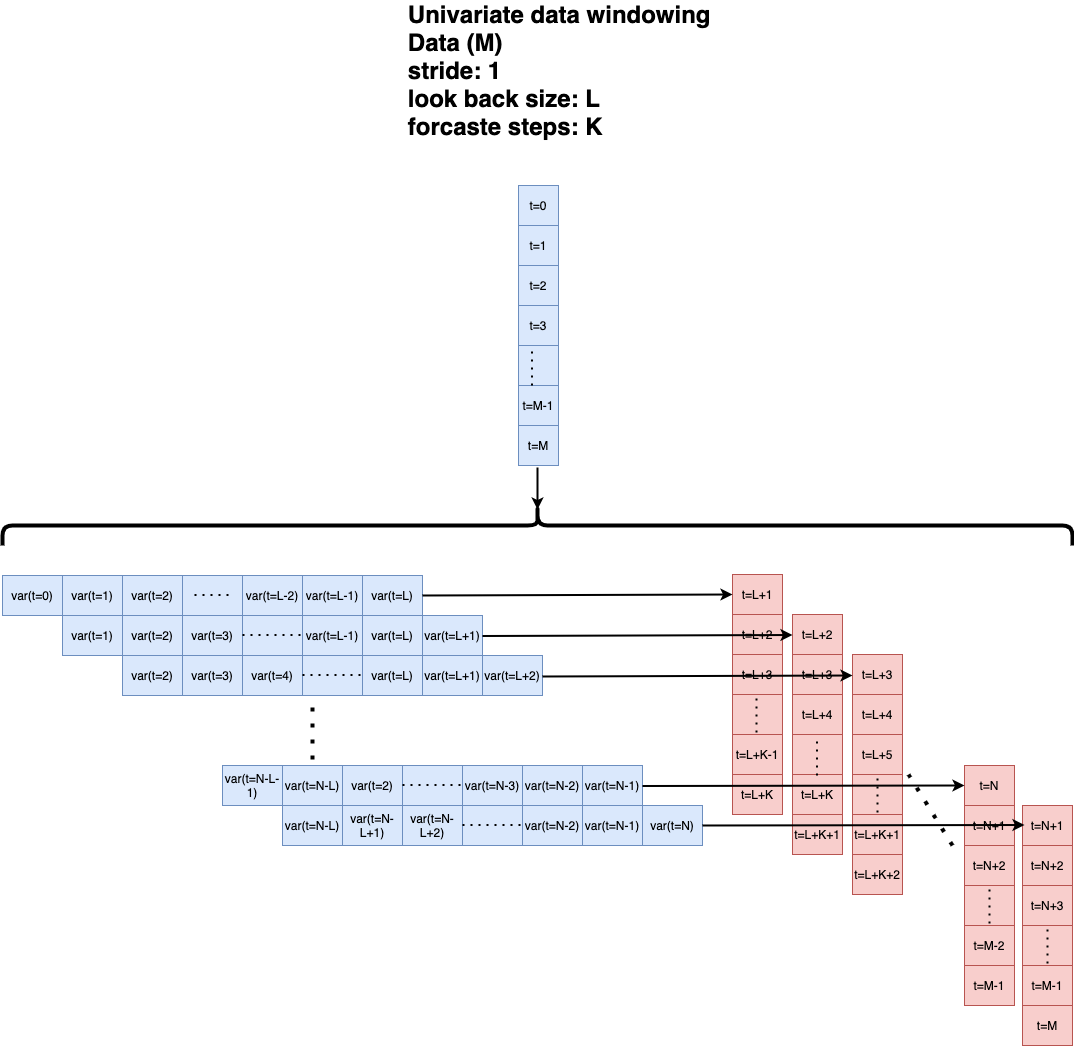

In [5]:
def UniWindowing(data, look_back:int=60, 
                 forward_steps:int=60, stride:int=1, drop_remainder=True, test_data=False):
    """
    data: pandas dataframe
    time_index: the datetime column
    look_back: (default: 60 minutes) number of prediction steps
    forward_step:(default: 60 minutes)  
    stride: (default:1) the amound of overlap determine by the window shift
    drop_remainder: (default: True) drops the reminders, where the length 
          is not enought for windowing 
    test_data: (default: False) this means there will be no overlape 
    """
    input_x, inputremain, output_y, outputremain  = list(), list(), list(), list() 
    # condition = look_back if look_back > forward_steps else forward_steps
    if test_data:
        for look in range(0, data.shape[0], forward_steps):
            if (look_back+forward_steps+look+1) > data.shape[0]:
                inputremain.append(data[look:look_back+look])
                outputremain.append(data[look+look_back:look_back+forward_steps+look])
                break
            input_x.append(data[look:look_back+look])
            output_y.append(data[look:forward_steps+look])
        if drop_remainder:
            return np.array(input_x), np.array(output_y)
        return np.array(input_x), np.array(output_y), np.array(inputremain), np.array(outputremain)
    
    else :
        for look in range(0, data.shape[0], stride):
            if (look_back+forward_steps+look) > data.shape[0]:
                inputremain.append(data[look:look_back+look])
                outputremain.append(data[look+look_back:look_back+forward_steps+look])
                break
            input_x.append(data[look:look_back+look])
            output_y.append(data[look+look_back:look_back+forward_steps+look])
        if drop_remainder:
            return np.array(input_x), np.array(output_y)
        return np.array(input_x), np.array(output_y), np.array(inputremain), np.array(outputremain)

In [119]:
def multiWindowing(data, target_index:int=0, look_back:int=60,
                   forward_steps:int=60, stride:int=1, drop_remainder=True, test_data=False):
    """
    data: pandas dataframe
    time_index: the datetime column
    look_back: (default: 60 minutes) number of prediction steps
    forward_step:(default: 60 minutes)
    drop_remainder: (default: True) drops the reminders, where the length
          is not enought for windowing
    stride: (default:1) the amound of overlap determine by the window shift
    test_data: (default: False) this means there will be no overlape
    """
    input_x, inputremain, output_y, outputremain  = list(), list(), list(), list()
    condition = look_back if look_back > forward_steps else forward_steps
    if test_data:
        for look in range(0, data.shape[0], forward_steps):
            if (look_back+forward_steps+look) > data.shape[0]:
                inputremain.append(data[look:look_back+look])
                outputremain.append(data[look+look_back+1:look_back+forward_steps+look+1, target_index])
                break
            input_x.append(data[look:look_back+look])
            output_y.append(data[look+look_back:look_back+forward_steps+look, target_index])
        if drop_remainder:
            return np.array(input_x), np.array(output_y)
        return np.array(input_x), np.array(output_y), np.array(inputremain), np.array(outputremain)

    else:
        for look in range(0, data.shape[0], stride):
            if (look_back+forward_steps+look) > data.shape[0]:
                inputremain.append(data[look:look_back+look])
                outputremain.append(data[ look+look_back:look_back+forward_steps+look, target_index])
                break
            input_x.append(data[look:look_back+look])
            output_y.append(data[look+look_back:look_back+forward_steps+look, target_index])
        if drop_remainder:
            return np.array(input_x), np.array(output_y)
        return np.array(input_x), np.array(output_y), np.array(inputremain), np.array(outputremain)

In [6]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)
def split_data(series, train_fraq, test_len=24*3):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data

In [141]:
n_steps, n_features, n_horizon, hidden_layer, lr  = 30*2, 3, 30, 512, 3e-4

In [76]:
d_data.columns

Index(['USD', 'EUR', 'JPY', 'GBP', 'CAD', 'CHF', 'INR', 'SAR', 'IDR', 'AED',
       'THB', 'KRW', 'ZAR', 'AUD', 'days', 'month', 'year'],
      dtype='object')

In [101]:
train_data, val_data, test_data = split_data(d_data['USD'], train_fraq=0.70, test_len=30*3)
train_ = UniWindowing(train_data.values, look_back=n_steps, forward_steps=n_horizon)
val_ = UniWindowing(val_data.values, look_back=n_steps, forward_steps=n_horizon)
test_ = UniWindowing(test_data.values, look_back=n_steps, forward_steps=n_horizon)
 

In [146]:
to_train = d_data[['USD','days', 'month']].copy()
scaler = MinMaxScaler()
to_train[['USD','days', 'month']] = scaler.fit_transform(d_data[['USD','days', 'month']].values)
to_train.shape

(11089, 3)

In [147]:
# get_result = multiWindowing(at, target_index=1, look_back=10, forward_steps=5)
train_data_scaled, val_data_scaled, test_data_scaled = split_data(to_train[['USD','days', 'month']].astype('float32').values, train_fraq=0.70, test_len=24*50)
train_scaled_ = multiWindowing(train_data_scaled,target_index=0, look_back=n_steps, forward_steps=n_horizon)
val_scaled_ = multiWindowing(val_data_scaled,target_index=0, look_back=n_steps, forward_steps=n_horizon)
test_scaled = multiWindowing(test_data_scaled,target_index=0, look_back=n_steps, forward_steps=n_horizon)
 

In [145]:
train_data_scaled, val_data_scaled, test_data_scaled = split_data(to_train[['USD','days', 'month', 'year']].astype('float32'), train_fraq=0.70, test_len=24*50)
train_scaled_ = UniWindowing(train_data_scaled, look_back=n_steps, forward_steps=n_horizon)
val_scaled_ = UniWindowing(val_data_scaled, look_back=n_steps, forward_steps=n_horizon)
test_scaled = UniWindowing(test_data_scaled, look_back=n_steps, forward_steps=n_horizon)
 

KeyError: "['year'] not in index"

In [132]:
train_scaled_[1].shape,train_scaled_[0].shape

((6833, 30), (6833, 60, 3))

### Univariate forecasting using MLP 

### Parameter for univariate forecasting:
ones step forecasting  
hidden layer : 512 

In [148]:
def dnn_model(n_steps, n_features, n_horizon, hidden_layer=512, lr=3e-4):
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_layer, activation='relu',input_shape=(n_steps,)),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    return model
 
dnn = dnn_model(n_steps, n_features, n_horizon, hidden_layer, lr )
dnn.summary()

Model: "dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               31232     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                15390     
Total params: 46,622
Trainable params: 46,622
Non-trainable params: 0
_________________________________________________________________


In [149]:
dnn_hist = dnn.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100


ValueError: in user code:

    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/souayboubagayoko/anaconda3/envs/test/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer dnn is incompatible with the layer: expected axis -1 of input shape to have value 60 but received input with shape (None, 60, 3)


In [49]:
SMALL_SIZE = 30
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.plot(dnn_hist.history['loss'], label='training loss')
# plt.plot(dnn_hist.history['val_loss'], label='validation loss')
# plt.legend()

In [138]:
n_features

4

In [150]:
def cnn_model(n_steps, n_horizon, n_features, hidden_layer=30, lr=3e-4, kernel_size=1):
    assert kernel_size < n_steps
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(hidden_layer, kernel_size=kernel_size, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_horizon)
        ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(n_steps, n_horizon,  n_features, hidden_layer, lr )
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 512)           2048      
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                921630    
Total params: 923,678
Trainable params: 923,678
Non-trainable params: 0
_________________________________________________________________


In [151]:
train_scaled_[0].shape

(6833, 60, 3)

In [152]:
cnn_hist = cnn.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100
428/428 [==============================] - 4s 9ms/step - loss: 0.0048 - mae: 0.0486 - val_loss: 0.0029 - val_mae: 0.0574
Epoch 2/100
428/428 [==============================] - 3s 8ms/step - loss: 1.3774e-04 - mae: 0.0111 - val_loss: 0.0024 - val_mae: 0.0488
Epoch 3/100
428/428 [==============================] - 3s 8ms/step - loss: 1.0406e-04 - mae: 0.0098 - val_loss: 0.0029 - val_mae: 0.0506
Epoch 4/100
428/428 [==============================] - 3s 7ms/step - loss: 8.1959e-05 - mae: 0.0085 - val_loss: 0.0029 - val_mae: 0.0541
Epoch 5/100
428/428 [==============================] - 3s 8ms/step - loss: 8.8070e-05 - mae: 0.0087 - val_loss: 0.0039 - val_mae: 0.0582
Epoch 6/100
428/428 [==============================] - 3s 7ms/step - loss: 1.0228e-04 - mae: 0.0093 - val_loss: 0.0057 - val_mae: 0.0654
Epoch 7/100
428/428 [==============================] - 3s 8ms/step - loss: 8.2520e-05 - mae: 0.0082 - val_loss: 0.0124 - val_mae: 0.1043
Epoch 8/100
428/428 [========================

In [124]:
cnn_hist = cnn.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100
429/429 [==============================] - 3s 5ms/step - loss: 0.0061 - mae: 0.0536 - val_loss: 8.7651e-04 - val_mae: 0.0325
Epoch 2/100
429/429 [==============================] - 2s 6ms/step - loss: 5.9537e-05 - mae: 0.0076 - val_loss: 5.4942e-04 - val_mae: 0.0246
Epoch 3/100
429/429 [==============================] - 2s 4ms/step - loss: 5.0711e-05 - mae: 0.0072 - val_loss: 4.0220e-04 - val_mae: 0.0215
Epoch 4/100
429/429 [==============================] - 2s 4ms/step - loss: 4.2958e-05 - mae: 0.0067 - val_loss: 7.0150e-04 - val_mae: 0.0291
Epoch 5/100
429/429 [==============================] - 2s 5ms/step - loss: 3.8475e-05 - mae: 0.0063 - val_loss: 4.1613e-04 - val_mae: 0.0217
Epoch 6/100
429/429 [==============================] - 2s 5ms/step - loss: 3.8243e-05 - mae: 0.0061 - val_loss: 3.4855e-04 - val_mae: 0.0199
Epoch 7/100
429/429 [==============================] - 2s 5ms/step - loss: 3.3459e-05 - mae: 0.0058 - val_loss: 4.3967e-04 - val_mae: 0.0221
Epoch 8/100
429/4

In [153]:
# The strongest so far  # https://github.com/Baichenjia/Tensorflow-TCN
class TemporalBlock(tf.keras.Model):
    def __init__(self, dilation_rate, nb_filters, kernel_size,  padding, dropout_rate=0.4, init_type='he_normal', activation='relu', apply_batch_norm=False):

        super(TemporalBlock, self).__init__()
        if init_type =='normal':
            init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
        else :
            init = tf.keras.initializers.HeNormal()
        assert padding in ['causal', 'same']
        self.apply_batch_norm = apply_batch_norm
        # block1
        self.conv1 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size,
                                dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
        self.batch1 = tf.keras.layers.BatchNormalization(axis=-1)
        self.ac1 = tf.keras.layers.Activation(activation)
        self.drop1 = tf.keras.layers.Dropout(rate=dropout_rate)

        # block2
        self.conv2 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size,
                            dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
        self.batch2 = tf.keras.layers.BatchNormalization(axis=-1)
        self.ac2 = tf.keras.layers.Activation(activation)
        self.drop2 = tf.keras.layers.Dropout(rate=dropout_rate)

        self.downsample = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                            padding='same', kernel_initializer=init)
        self.ac3 = tf.keras.layers.Activation(activation)


    def call(self, x, training):
        prev_x = x
        x = self.conv1(x)
        if self.apply_batch_norm:
            x = self.batch1(x)
        x = self.ac1(x)
        x = self.drop1(x) if training else x

        x = self.conv2(x)
        if self.apply_batch_norm:
            x = self.batch2(x)
        x = self.ac2(x)
        x = self.drop2(x) if training else x

        if prev_x.shape[-1] != x.shape[-1]:    # match the dimention
            prev_x = self.downsample(prev_x)
        # assert prev_x.shape == x.shape

        return self.ac3(prev_x + x)            # skip connection


class TCN_CNN(tf.keras.Model):
    def __init__(self, num_channels, kernel_size=2,   dropout=0.4,  padding='causal'):
    	# num_channels is a list contains hidden sizes of Conv1D
        super(TCN_CNN, self).__init__()
        assert isinstance(num_channels, list)
        self.conv_layers = [
                            TemporalBlock(dilation_rate=2**i, nb_filters= channels, kernel_size= kernel_size, padding= padding, dropout_rate=dropout) \
                            for i, channels in enumerate(num_channels)]

        self.globalave = tf.keras.layers.GlobalAveragePooling1D()
        self.globalmax = tf.keras.layers.GlobalMaxPooling1D()
        self.dense1 =tf.keras.layers.Dense(2024, activation="relu")
        self.drop   = tf.keras.layers.Dropout(0.1)
        self.out = tf.keras.layers.Dense(1)


    def call(self, x_input, training):
        for it, conv in enumerate(self.conv_layers):
            if not it:
                x = conv(x_input, training)
                continue
            x = conv(x, training)
        avg = self.globalave(x)
        max = self.globalmax(x)
        concat = tf.keras.layers.concatenate([avg, max])
        d1 = self.dense1(concat)
        d1 = self.drop(d1) if training else d1
        out = self.out(d1)
        return  out


In [154]:
TCN_model = TCN_CNN([128,64], kernel_size=3)
TCN_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [127]:
tcn_hist = TCN_model.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100
429/429 [==============================] - 11s 20ms/step - loss: 0.1422 - mae: 0.1937 - val_loss: 0.0290 - val_mae: 0.1486
Epoch 2/100
429/429 [==============================] - 9s 21ms/step - loss: 6.9861e-04 - mae: 0.0201 - val_loss: 0.0078 - val_mae: 0.0674
Epoch 3/100
429/429 [==============================] - 9s 22ms/step - loss: 3.1977e-04 - mae: 0.0134 - val_loss: 0.0050 - val_mae: 0.0534
Epoch 4/100
429/429 [==============================] - 9s 22ms/step - loss: 2.4921e-04 - mae: 0.0119 - val_loss: 0.0057 - val_mae: 0.0549
Epoch 5/100
429/429 [==============================] - 9s 21ms/step - loss: 2.5137e-04 - mae: 0.0115 - val_loss: 0.0039 - val_mae: 0.0459
Epoch 6/100
429/429 [==============================] - 9s 21ms/step - loss: 1.9927e-04 - mae: 0.0104 - val_loss: 0.0030 - val_mae: 0.0427
Epoch 7/100
429/429 [==============================] - 9s 22ms/step - loss: 1.9711e-04 - mae: 0.0104 - val_loss: 0.0059 - val_mae: 0.0566
Epoch 8/100
429/429 [================

In [39]:
tcn_hist = TCN_model.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100
428/428 [==============================] - 13s 32ms/step - loss: 1.1934e-04 - mae: 0.0075 - val_loss: 0.0564 - val_mae: 0.2087
Epoch 2/100
428/428 [==============================] - 9s 20ms/step - loss: 1.2065e-04 - mae: 0.0075 - val_loss: 0.0409 - val_mae: 0.1788
Epoch 3/100
428/428 [==============================] - 10s 24ms/step - loss: 1.2019e-04 - mae: 0.0075 - val_loss: 0.0387 - val_mae: 0.1763
Epoch 4/100
428/428 [==============================] - 9s 21ms/step - loss: 1.2050e-04 - mae: 0.0076 - val_loss: 0.0257 - val_mae: 0.1418
Epoch 5/100
428/428 [==============================] - 9s 21ms/step - loss: 1.1854e-04 - mae: 0.0075 - val_loss: 0.0429 - val_mae: 0.1822
Epoch 6/100
428/428 [==============================] - 10s 24ms/step - loss: 1.1723e-04 - mae: 0.0074 - val_loss: 0.0265 - val_mae: 0.1444
Epoch 7/100
428/428 [==============================] - 9s 21ms/step - loss: 1.2142e-04 - mae: 0.0075 - val_loss: 0.0337 - val_mae: 0.1598
Epoch 8/100
428/428 [==========

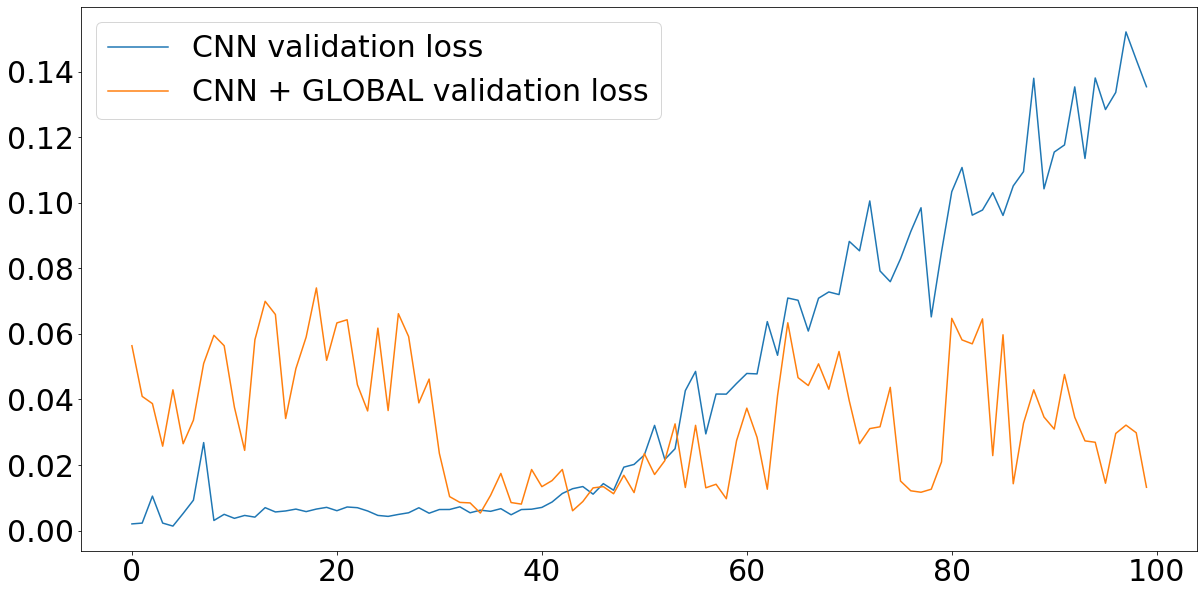

In [50]:
plt.plot(cnn_hist.history['val_loss'], label='CNN validation loss')
plt.plot(tcn_hist.history['val_loss'], label='CNN + GLOBAL validation loss')
plt.legend()

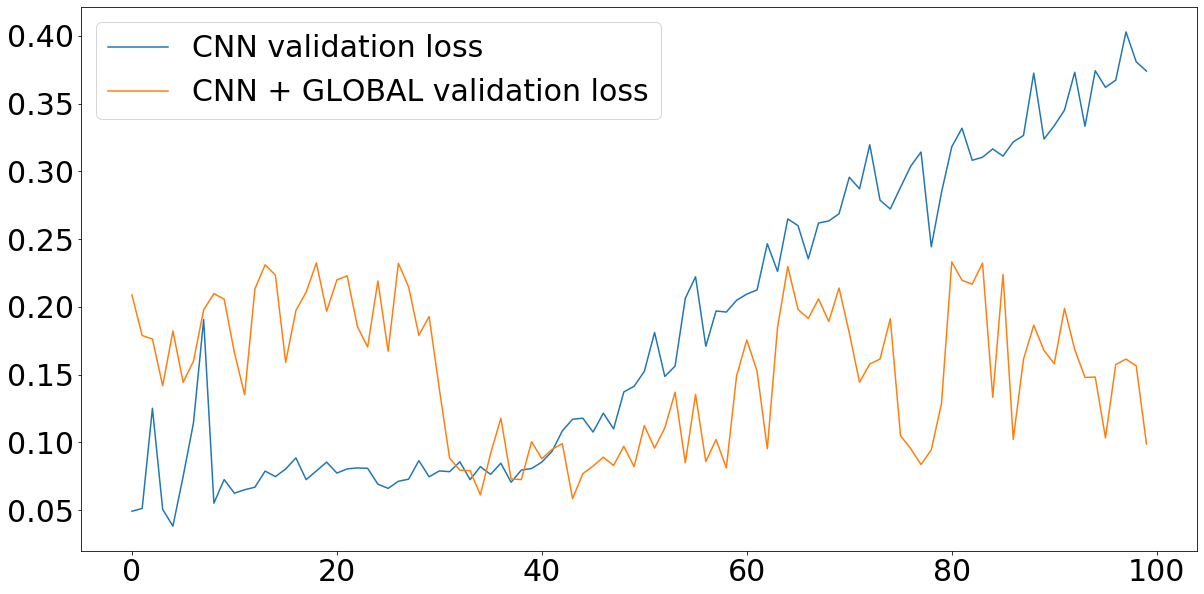

In [51]:
plt.plot(cnn_hist.history['val_mae'], label='CNN validation loss')
plt.plot(tcn_hist.history['val_mae'], label='CNN + GLOBAL validation loss')
plt.legend()

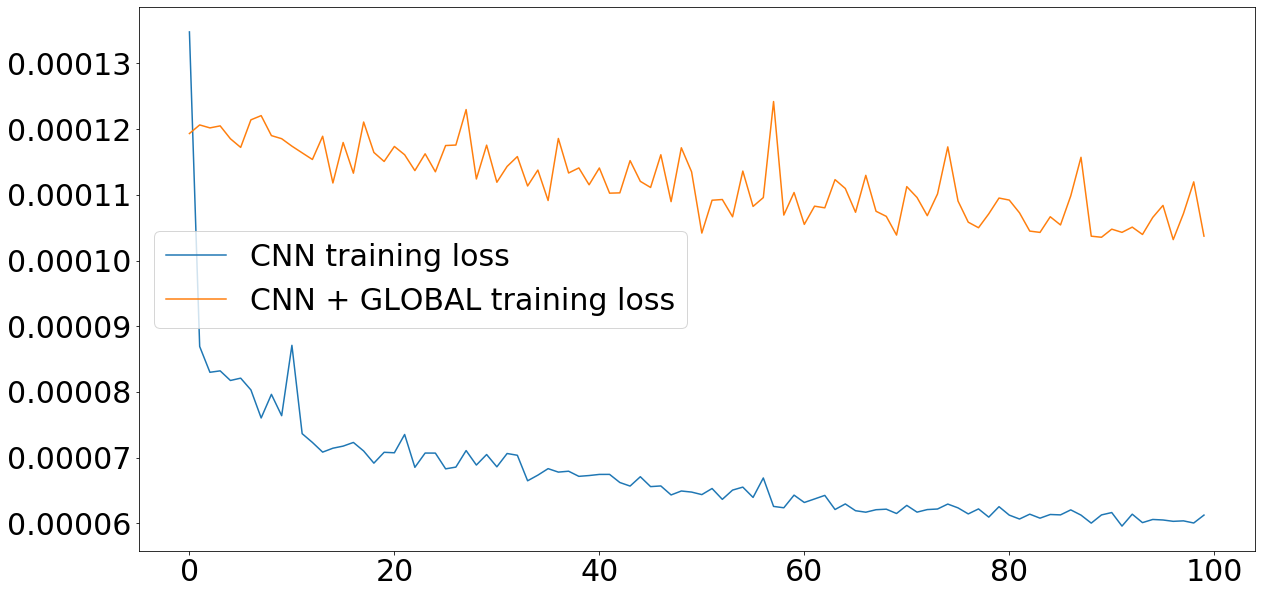

In [52]:
plt.plot(cnn_hist.history['loss'], label='CNN training loss')
plt.plot(tcn_hist.history['loss'], label='CNN + GLOBAL training loss')
plt.legend()

In [45]:
class AdditiveAttentionForSeq(tf.keras.layers.Layer):
    def __init__(self, attention_size, **kwargs):
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.Dense(attention_size)

    def call(self, state, encoder_outputs):

        seq_len = encoder_outputs.shape[1]
        averaged_state = tf.reduce_mean(tf.stack(state, axis = 1), axis = 1)
        state_rep = tf.repeat(tf.expand_dims(averaged_state, axis = 1), repeats = seq_len, axis = 1)
        concat = tf.concat((state_rep, encoder_outputs), axis = -1)
        scores = tf.nn.tanh(self.attention(concat))
        attention_weights = tf.nn.softmax(tf.reduce_sum(scores, axis = -1), axis = -1)
        return tf.matmul(tf.expand_dims(attention_weights, axis = 1), encoder_outputs)


class Seq2SeqAttentionDecoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.attention = AdditiveAttentionForSeq(attention_size = 32)
        self.dense = tf.keras.layers.Dense(1)

    def init_state(self, enc_outputs, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state)


    def call(self, dec_input, state,enc_outputs, **kwargs):
        # shape of context: (batch_size, 1, hidden_dims)
        context = self.attention(state, enc_outputs)
        rnn_input = tf.concat((dec_input, context), axis = -1) # Shape of rnn_input: (batch_size, 1, (num_features + hidden_dims))
        rnn_output = self.rnn(rnn_input, state, **kwargs)
        # Shape of rnn_output[0]: (batch_size, 1, num_hiddens)
        # Shape of rnn_output[1]: (num_layers, batch_size, num_hiddens)
        output = self.dense(tf.squeeze(rnn_output[0], axis = 1)) # Shape of output: (batch_sizef, 1)
        return output


class TCN(tf.keras.Model):
    def __init__(self, num_channels, kernel_size=2, num_rnn_layer=2, rnn_hidden=64, dropout=0., rnn_dropout=0.):
    	# num_channels is a list contains hidden sizes of Conv1D
        super(TCN, self).__init__()
        assert isinstance(num_channels, list)
        self.conv_layers = [
                            TemporalBlock(dilation_rate=2**i, nb_filters= channels, kernel_size= kernel_size, padding='causal', dropout_rate=dropout) \
                            for i, channels in enumerate(num_channels)]

        # set encoder
        self.rnn_enc = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(rnn_hidden, dropout = rnn_dropout)
                                                                        for _ in range(num_rnn_layer)]),
                                       return_sequences = True, return_state = True)

        self.rnn_dec = Seq2SeqAttentionDecoder(num_hiddens=rnn_hidden, num_layers=num_rnn_layer, dropout = rnn_dropout)
        self.out = tf.keras.layers.Dense(1)


    def call(self, x_input, training):
        enc = self.rnn_enc(x_input)
        enc_output= enc[0]
        enc_state = enc[1:]
        for it, conv in enumerate(self.conv_layers):
            if not it:
                x = conv(enc_output, training)
                continue
            x = conv(x, training)
        dec_input = x_input[:, -1, tf.newaxis]
        #input: dec_input, state, enc_outputs
        dec_output = self.rnn_dec(dec_input, enc_state, x)
        # average = self.averpool(dec_output[0])
        # out = self.out(average)
        return  dec_output

In [48]:
tcn_gru_model = TCN([16,8], kernel_size=5)
tcn_gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
tcn_gru_hist = tcn_gru_model.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100
428/428 [==============================] - 31s 51ms/step - loss: 6.0262e-04 - mae: 0.0139 - val_loss: 0.0013 - val_mae: 0.0279
Epoch 2/100
428/428 [==============================] - 21s 50ms/step - loss: 1.5538e-04 - mae: 0.0074 - val_loss: 0.0027 - val_mae: 0.0421
Epoch 3/100
428/428 [==============================] - 22s 52ms/step - loss: 1.3833e-04 - mae: 0.0072 - val_loss: 0.0050 - val_mae: 0.0588
Epoch 4/100
428/428 [==============================] - 24s 57ms/step - loss: 1.4554e-04 - mae: 0.0074 - val_loss: 0.0049 - val_mae: 0.0573
Epoch 5/100
428/428 [==============================] - 22s 51ms/step - loss: 1.3315e-04 - mae: 0.0071 - val_loss: 0.0021 - val_mae: 0.0345
Epoch 6/100
428/428 [==============================] - 23s 55ms/step - loss: 1.3590e-04 - mae: 0.0073 - val_loss: 0.0098 - val_mae: 0.0842
Epoch 7/100
428/428 [==============================] - 23s 53ms/step - loss: 1.2140e-04 - mae: 0.0067 - val_loss: 0.0137 - val_mae: 0.0983
Epoch 8/100
428/428 [======

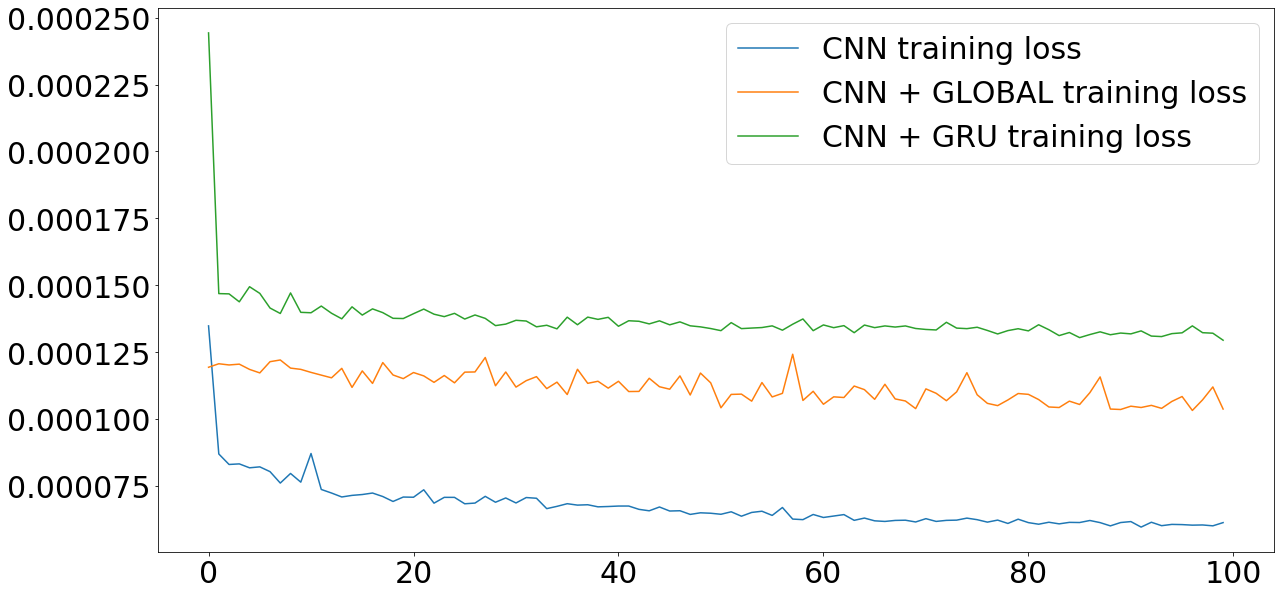

In [53]:
plt.plot(cnn_hist.history['loss'], label='CNN training loss')
plt.plot(tcn_hist.history['loss'], label='CNN + GLOBAL training loss')
plt.plot(tcn_gru_hist.history['loss'], label='CNN + GRU training loss')
plt.legend()

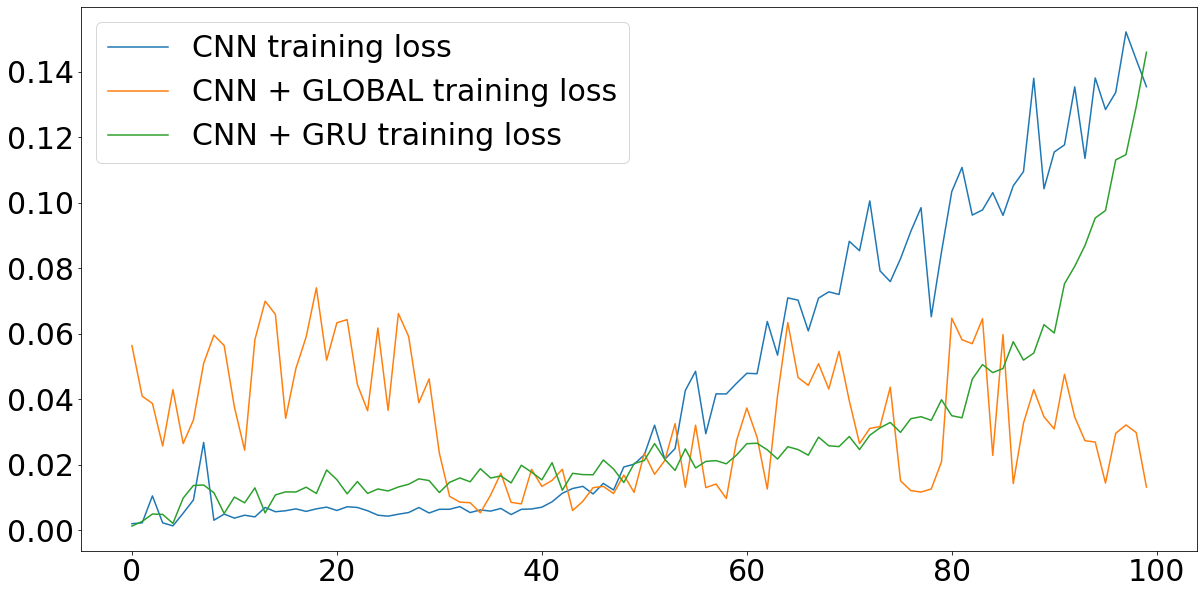

In [54]:
plt.plot(cnn_hist.history['val_loss'], label='CNN training loss')
plt.plot(tcn_hist.history['val_loss'], label='CNN + GLOBAL training loss')
plt.plot(tcn_gru_hist.history['val_loss'], label='CNN + GRU training loss')
plt.legend()

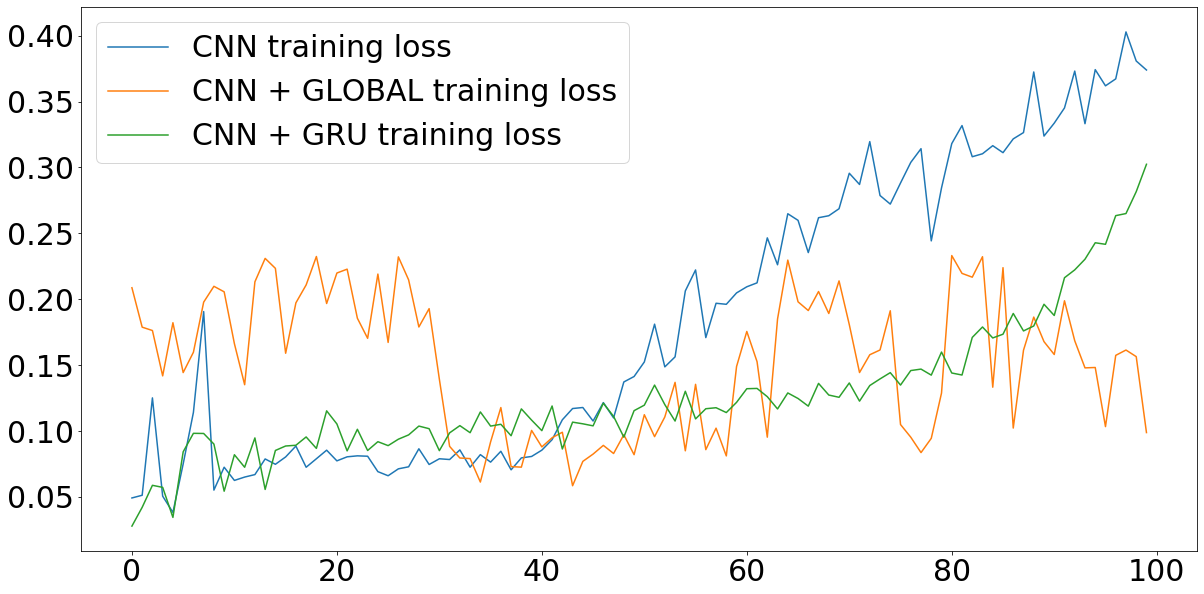

In [55]:
plt.plot(cnn_hist.history['val_mae'], label='CNN training loss')
plt.plot(tcn_hist.history['val_mae'], label='CNN + GLOBAL training loss')
plt.plot(tcn_gru_hist.history['val_mae'], label='CNN + GRU training loss')
plt.legend()

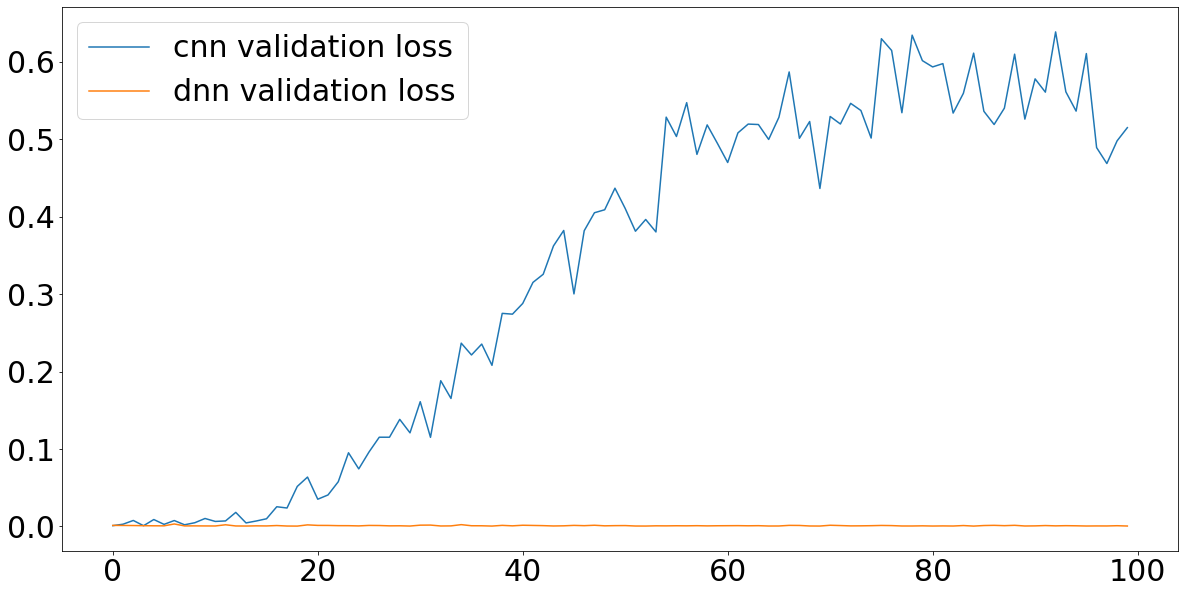

In [ ]:
plt.plot(cnn_hist.history['val_loss'], label='cnn validation loss')
plt.plot(dnn_hist.history['val_loss'], label='dnn validation loss')
plt.legend()

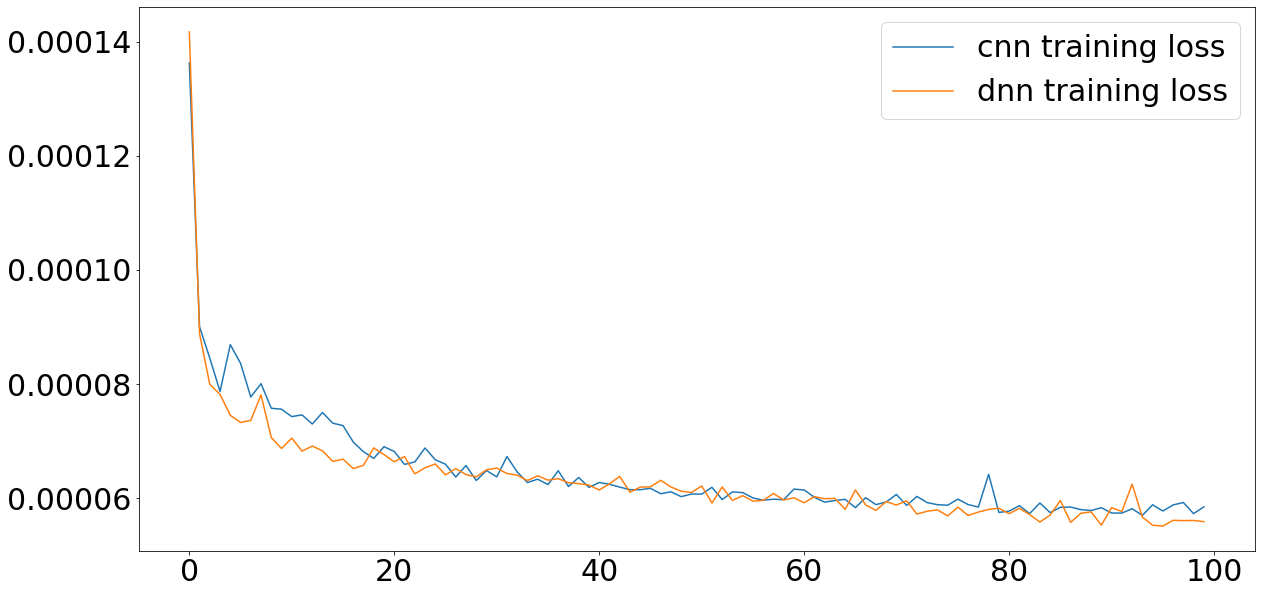

In [ ]:
plt.plot(cnn_hist.history['loss'], label='cnn training loss')
plt.plot(dnn_hist.history['loss'], label='dnn training loss')
plt.legend()

### here there is need to scaled the data otherwise, one will end updata with exploding gradient, RNN like network are prone to exploding and/or vaniashing gradient 
here you need to alk about vanishing and exploding gradient and how gradient cliping and data scaling is importang to solve the issue 

In [ ]:
#from keras.layers.core.activation import Activation
def lstm_model(n_steps, n_horizon, n_features, hidden_layer=512, lr=3e-4):
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(hidden_layer, input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.Activation(tf.keras.activations.tanh),
        tf.keras.layers.LSTM(48, return_sequences=False),
        tf.keras.layers.Activation(tf.keras.activations.relu),
        # tf.keras.layers.LSTM(hidden_layer, activation='relu', input_shape=(n_steps, n_features)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=0.5) # clipping for gradient exploding 
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(n_steps, n_horizon,n_features, hidden_layer, lr)
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 512)           1052672   
                                                                 
 activation (Activation)     (None, 60, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 48)                107712    
                                                                 
 activation_1 (Activation)   (None, 48)                0         
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 30)                1470      
                                                                 
Total params: 1,161,854
Trainable params: 1,161,854
Non-traina

In [ ]:
lstm_test = lstm_model(n_steps, n_horizon,n_features, hidden_layer=64)
lstm_test.summary()
lstm_hist_test = lstm_test.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 activation (Activation)     (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48)                21696     
                                                                 
 activation_1 (Activation)   (None, 48)                0         
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 30)                1470      
                                                                 
Total params: 40,062
Trainable params: 40,062
Non-trainable pa

In [ ]:
lstm_hist = lstm.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100
428/428 [==============================] - 15s 14ms/step - loss: 1.7890e-04 - mae: 0.0109 - val_loss: 0.0226 - val_mae: 0.1750
Epoch 2/100
428/428 [==============================] - 6s 14ms/step - loss: 9.1030e-05 - mae: 0.0083 - val_loss: 0.0193 - val_mae: 0.1610
Epoch 3/100
428/428 [==============================] - 6s 13ms/step - loss: 8.0891e-05 - mae: 0.0077 - val_loss: 0.0164 - val_mae: 0.1478
Epoch 4/100
428/428 [==============================] - 5s 12ms/step - loss: 8.1570e-05 - mae: 0.0078 - val_loss: 0.0170 - val_mae: 0.1509
Epoch 5/100
428/428 [==============================] - 5s 12ms/step - loss: 7.7153e-05 - mae: 0.0075 - val_loss: 0.0149 - val_mae: 0.1387
Epoch 6/100
428/428 [==============================] - 5s 12ms/step - loss: 7.6279e-05 - mae: 0.0075 - val_loss: 0.0163 - val_mae: 0.1472
Epoch 7/100
428/428 [==============================] - 5s 12ms/step - loss: 7.3817e-05 - mae: 0.0073 - val_loss: 0.0145 - val_mae: 0.1359
Epoch 8/100
428/428 [============

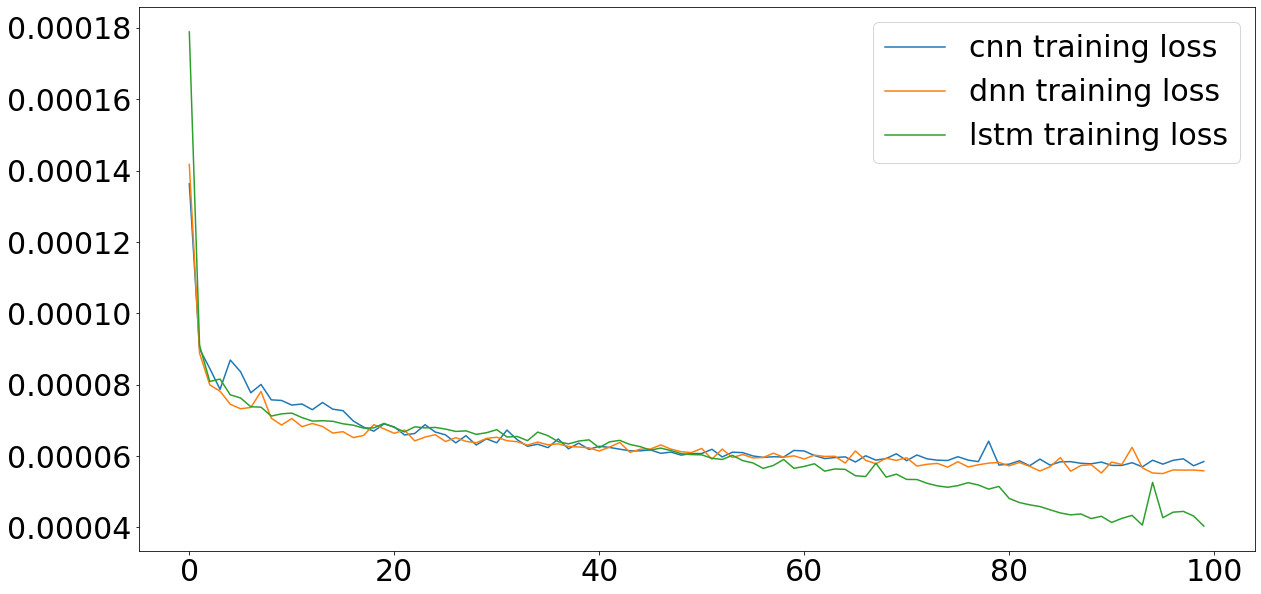

In [ ]:
plt.plot(cnn_hist.history['loss'], label='cnn training loss')
plt.plot(dnn_hist.history['loss'], label='dnn training loss')
plt.plot(lstm_hist.history['loss'], label='lstm training loss')
plt.legend()

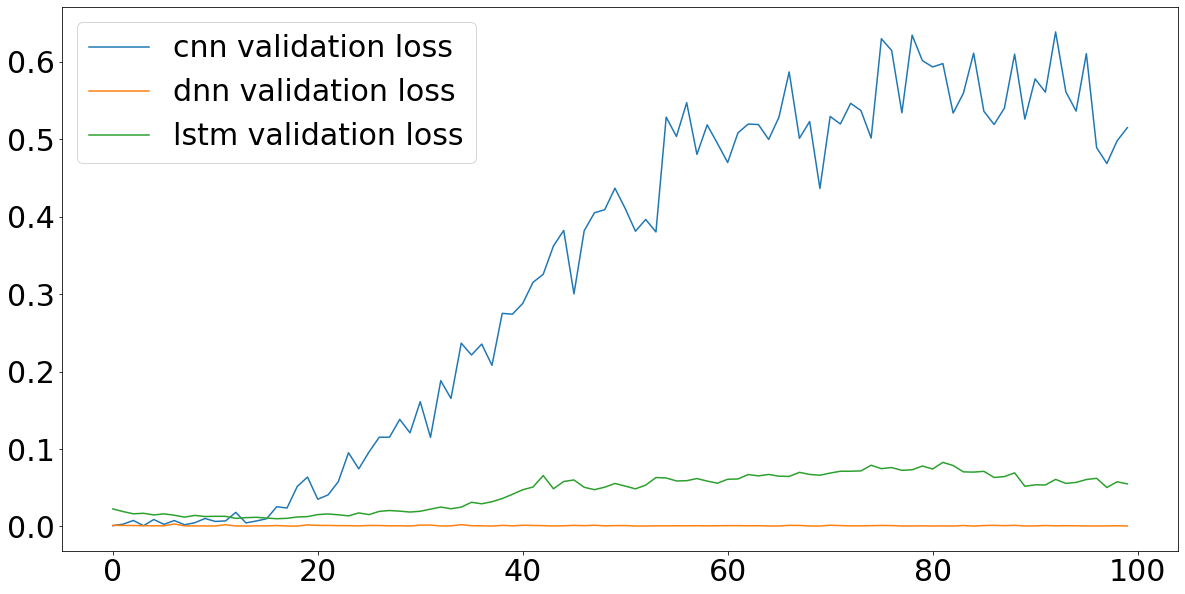

In [ ]:
plt.plot(cnn_hist.history['val_loss'], label='cnn validation loss')
plt.plot(dnn_hist.history['val_loss'], label='dnn validation loss')
plt.plot(lstm_hist.history['val_loss'] , label='lstm validation loss')
plt.legend()

In [ ]:
def lstm_cnn_model(n_steps, n_features, n_horizon, hidden_layer, lr, kernel_size=1):
    
    tf.keras.backend.clear_session()
    assert kernel_size < n_steps
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(hidden_layer, kernel_size=kernel_size, input_shape=(n_steps,n_features)),
        tf.keras.layers.Activation(tf.keras.activations.relu),
        tf.keras.layers.LSTM(hidden_layer, return_sequences=False),
        tf.keras.layers.Activation(tf.keras.activations.relu),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(n_steps, n_features, n_horizon, hidden_layer, lr)
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 512)           1024      
                                                                 
 activation (Activation)     (None, 60, 512)           0         
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 30)                15390     
                                                                 
Total params: 2,115,614
Trainable params: 2,115,614
Non-tr

In [ ]:
lstm_cnn_hist = lstm_cnn.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100
428/428 [==============================] - 8s 14ms/step - loss: 1.2731e-04 - mae: 0.0094 - val_loss: 0.0028 - val_mae: 0.0603
Epoch 2/100
428/428 [==============================] - 6s 13ms/step - loss: 7.5455e-05 - mae: 0.0074 - val_loss: 0.0038 - val_mae: 0.0700
Epoch 3/100
428/428 [==============================] - 6s 13ms/step - loss: 7.6848e-05 - mae: 0.0076 - val_loss: 0.0039 - val_mae: 0.0694
Epoch 4/100
428/428 [==============================] - 5s 12ms/step - loss: 7.3845e-05 - mae: 0.0075 - val_loss: 0.0054 - val_mae: 0.0840
Epoch 5/100
428/428 [==============================] - 5s 12ms/step - loss: 7.4288e-05 - mae: 0.0074 - val_loss: 0.0069 - val_mae: 0.0969
Epoch 6/100
428/428 [==============================] - 6s 13ms/step - loss: 7.1413e-05 - mae: 0.0072 - val_loss: 0.0061 - val_mae: 0.0870
Epoch 7/100
428/428 [==============================] - 6s 13ms/step - loss: 6.9501e-05 - mae: 0.0070 - val_loss: 0.0106 - val_mae: 0.1190
Epoch 8/100
428/428 [=============

In [ ]:
dnn.save('/content/gdrive/MyDrive/Thesis/dnn.h5')
cnn.save('/content/gdrive/MyDrive/Thesis/cnn.h5')
lstm.save('/content/gdrive/MyDrive/Thesis/lstm.h5')
lstm_cnn.save('/content/gdrive/MyDrive/Thesis/lstm_cnn.h5')

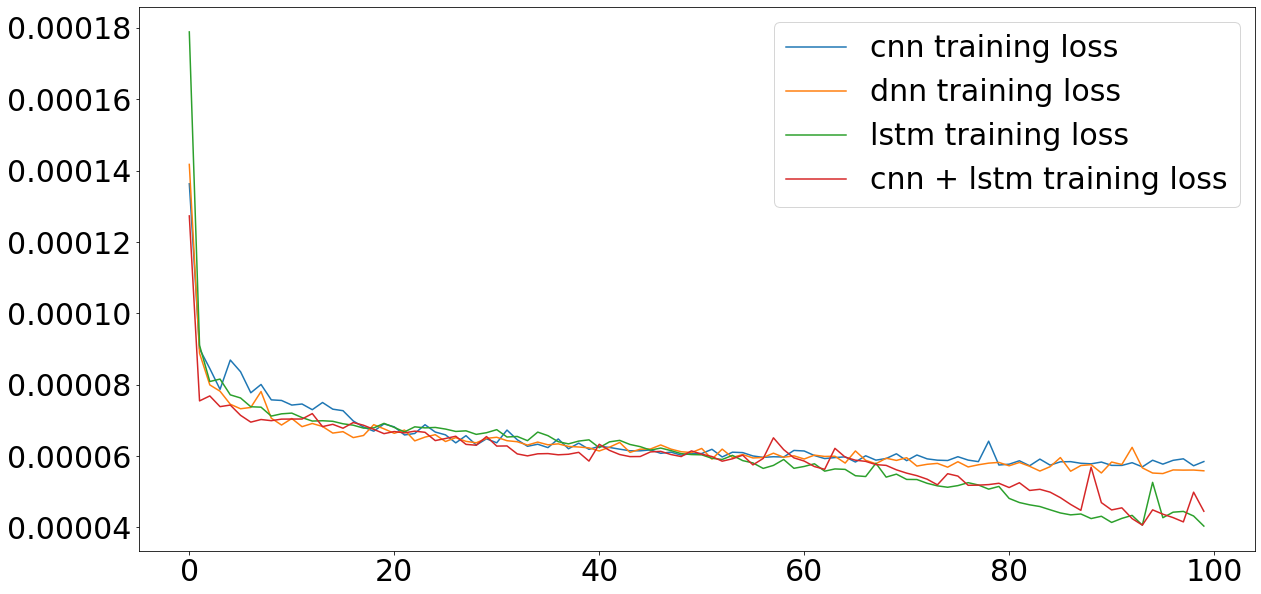

In [ ]:
plt.plot(cnn_hist.history['loss'], label='cnn training loss')
plt.plot(dnn_hist.history['loss'], label='dnn training loss')
plt.plot(lstm_hist.history['loss'] , label='lstm training loss')
plt.plot(lstm_cnn_hist.history['loss'], label= 'cnn + lstm training loss')
plt.legend()

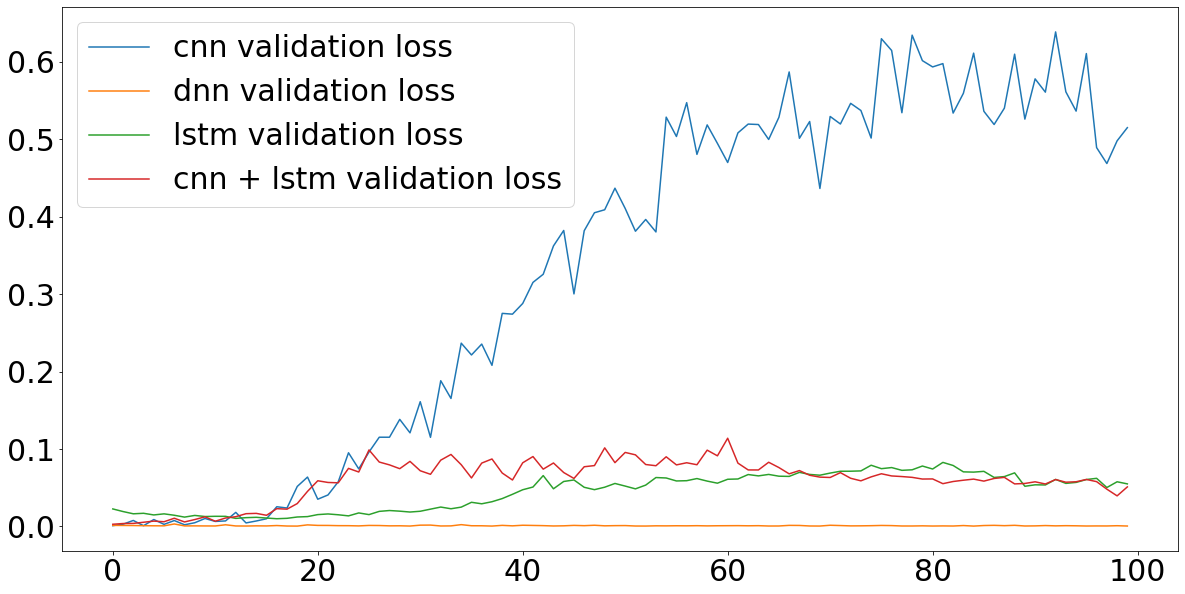

In [ ]:
plt.plot(cnn_hist.history['val_loss'], label='cnn validation loss')
plt.plot(dnn_hist.history['val_loss'], label='dnn validation loss')
plt.plot(lstm_hist.history['val_loss'] , label='lstm validation loss')
plt.plot(lstm_cnn_hist.history['val_loss'], label='cnn + lstm validation loss')
plt.legend()

### Increasing the hidden layer size 

In [ ]:
#hidden_layer_list = [512, 128, 64]
hidden_layer_list = [64, 40]

In [ ]:
# DNN
def dnn_dense_model(n_steps, n_features, n_horizon, hidden_layer=512, lr=3e-4):
    tf.keras.backend.clear_session()
    assert isinstance(hidden_layer, list), 'the hidden should be a list'
    model = tf.keras.models.Sequential()
    for it , hidden in enumerate(hidden_layer):
        if not it:
            model.add(tf.keras.layers.Dense(hidden, activation='relu',input_shape=(n_steps,)))
        else : 
            model.add(tf.keras.layers.Dense(hidden , activation='relu'))
        
    model.add(tf.keras.layers.Dense(n_horizon))
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    return model
 
dnn_dense = dnn_dense_model(n_steps, n_features, n_horizon, hidden_layer_list, lr )
dnn_dense.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3904      
                                                                 
 dense_1 (Dense)             (None, 40)                2600      
                                                                 
 dense_2 (Dense)             (None, 30)                1230      
                                                                 
Total params: 7,734
Trainable params: 7,734
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
dnn_dense_hist = dnn_dense.fit(train_scaled_[0], train_scaled_[1], validation_data=(val_scaled_[0], val_scaled_[1]), batch_size=16, epochs=100)

Epoch 1/100
428/428 [==============================] - 2s 4ms/step - loss: 2.4245e-04 - mae: 0.0118 - val_loss: 0.0015 - val_mae: 0.0432
Epoch 2/100
428/428 [==============================] - 1s 3ms/step - loss: 8.1220e-05 - mae: 0.0075 - val_loss: 0.0013 - val_mae: 0.0391
Epoch 3/100
428/428 [==============================] - 1s 3ms/step - loss: 7.7438e-05 - mae: 0.0075 - val_loss: 0.0014 - val_mae: 0.0410
Epoch 4/100
428/428 [==============================] - 1s 3ms/step - loss: 7.5534e-05 - mae: 0.0074 - val_loss: 0.0016 - val_mae: 0.0438
Epoch 5/100
428/428 [==============================] - 1s 3ms/step - loss: 7.4331e-05 - mae: 0.0074 - val_loss: 0.0012 - val_mae: 0.0375
Epoch 6/100
428/428 [==============================] - 1s 3ms/step - loss: 7.3568e-05 - mae: 0.0073 - val_loss: 0.0032 - val_mae: 0.0662
Epoch 7/100
428/428 [==============================] - 2s 4ms/step - loss: 7.0576e-05 - mae: 0.0071 - val_loss: 0.0013 - val_mae: 0.0382
Epoch 8/100
428/428 [====================

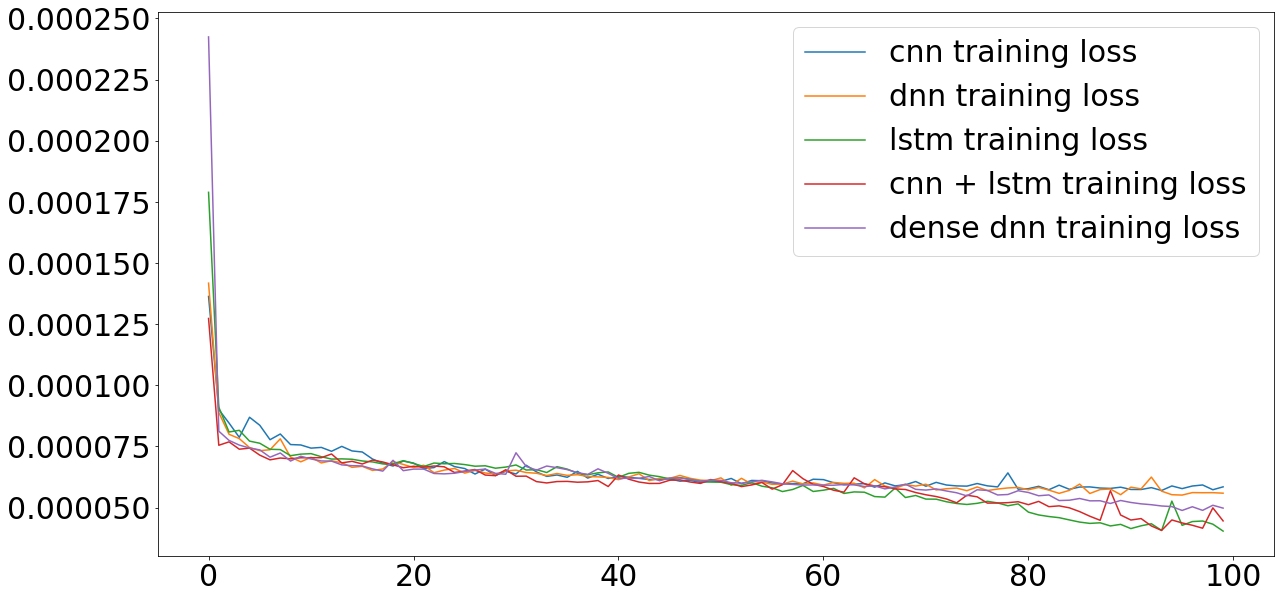

In [ ]:
plt.plot(cnn_hist.history['loss'], label='cnn training loss')
plt.plot(dnn_hist.history['loss'], label='dnn training loss')
plt.plot(lstm_hist.history['loss'] , label='lstm training loss')
plt.plot(lstm_cnn_hist.history['loss'], label= 'cnn + lstm training loss')
plt.plot(dnn_dense_hist.history['loss'] , label='dense dnn training loss')
plt.legend()

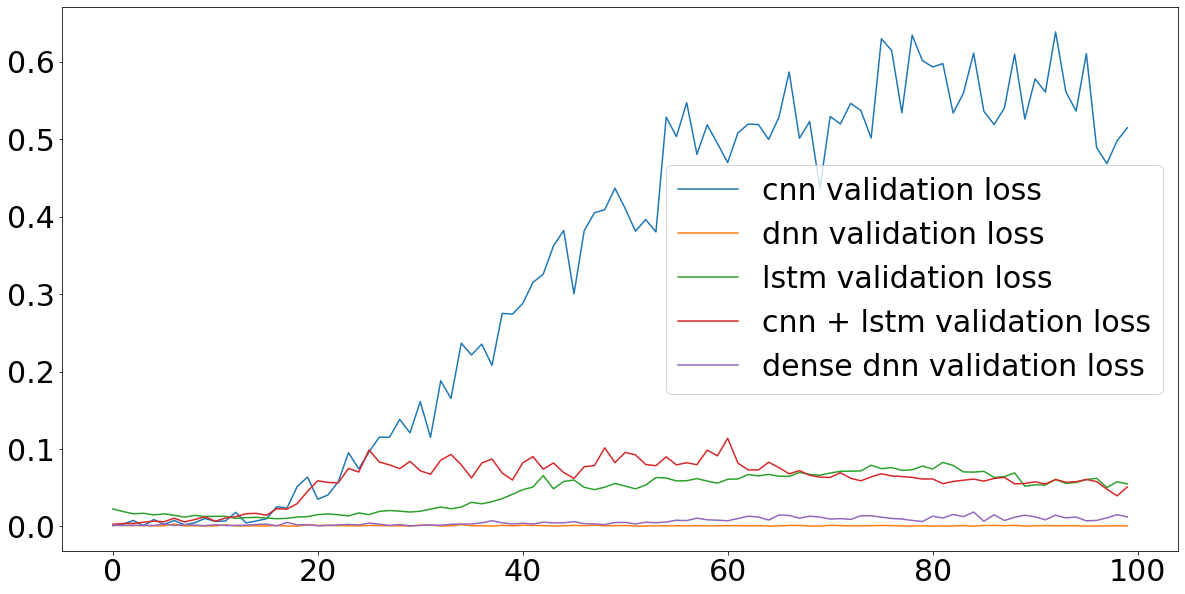

In [ ]:
plt.plot(cnn_hist.history['val_loss'], label='cnn validation loss')
plt.plot(dnn_hist.history['val_loss'], label='dnn validation loss')
plt.plot(lstm_hist.history['val_loss'] , label='lstm validation loss')
plt.plot(lstm_cnn_hist.history['val_loss'], label='cnn + lstm validation loss')
plt.plot(dnn_dense_hist.history['val_loss'], label='dense dnn validation loss')
plt.legend()

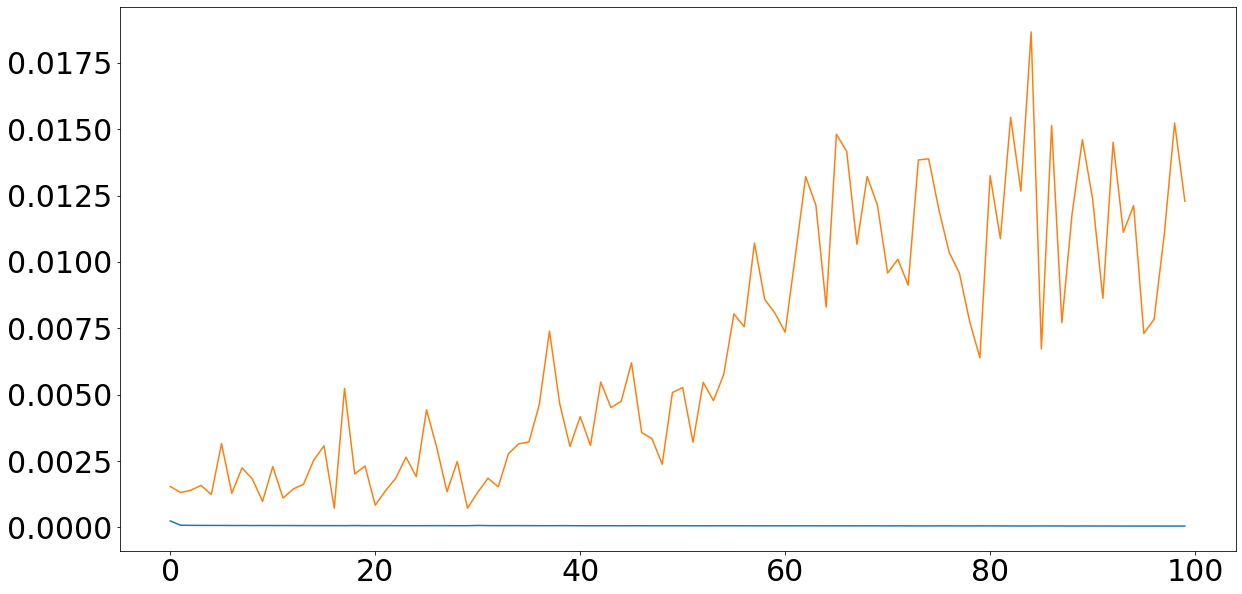

In [ ]:
plt.plot(dnn_dense_hist.history['loss'], label='dense dnn training loss')
plt.plot(dnn_dense_hist.history['val_loss'], label='dense dnn validation loss')

In [ ]:
dnn_dense.save('/content/gdrive/MyDrive/Thesis/dnn_dense.h5')

Note: We can observe that the model overfit, possible the reason: 


1.   Not enough data to train a deep neural network 
2.   The model is too dense, hence it memorize the training data, thereby not able to generalize or pick the true signal 
3. The forecast steps: In this case the forecast step might be longer, whereas the data does not contain enought information to mappe the input to the target. Addtionally, the problem of cumulative error, which is recurrent in forecasting occured. 




## Saving the models #

In [ ]:
# DNN
def cnn_dense_model(n_steps, n_features, n_horizon, hidden_layer=512, lr=3e-4):
    tf.keras.backend.clear_session()
    assert isinstance(hidden_layer, list), 'the hidden should be a list'
    model = tf.keras.models.Sequential()
    for it , hidden in enumerate(hidden_layer):
        if not it:
            model.add(tf.keras.layers.Dense(hidden, activation='relu',input_shape=(n_steps,)))
        else : 
            model.add(tf.keras.layers.Desne(hidden , activation='relu'))
        
    model.add(tf.keras.layers.Dense(n_horizon))
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    return model
 
dnn_dense = cnn_dense_model(n_steps, n_features, n_horizon, hidden_layer_list, lr )
dnn_dense.summary()

In [ ]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data.values.astype('float32'), axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(np.asarray(data).astype('float32'))
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    # ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

tf.random.set_seed(42)

n_steps = 3
n_horizon = 2
batch_size = 1
shuffle_buffer = 3


ds = window_dataset(test_df, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)


In [ ]:
for it , (i,j) in enumerate(ds):
  print(f'inpu {i} target { j}')
  if it > 3 :
    break

inpu [[[0. 1. 2.]
  [3. 4. 5.]
  [6. 7. 8.]]] target [[[ 9.]
  [12.]]]
inpu [[[ 6.  7.  8.]
  [ 9. 10. 11.]
  [12. 13. 14.]]] target [[[15.]
  [18.]]]
inpu [[[12. 13. 14.]
  [15. 16. 17.]
  [18. 19. 20.]]] target [[[21.]
  [24.]]]
inpu [[[18. 19. 20.]
  [21. 22. 23.]
  [24. 25. 26.]]] target [[[27.]
  [30.]]]
inpu [[[24. 25. 26.]
  [27. 28. 29.]
  [30. 31. 32.]]] target [[[33.]
  [36.]]]


In [ ]:
d_data.head(100)

,USD,EUR,JPY,GBP,CAD,CHF,INR,SAR,IDR,AED,THB,KRW,ZAR,AUD
date,,,,,,,,,,,,,,
1979-01-02,226.8,137.29,43164.91,111.45,263.74,359.62,1792.85,735.6,138160.45,851.29,4454.55,107470.04,194.56,193.61
1979-01-03,218.6,134.01,43717.9,107.98,264.39,365.87,1802.15,739.42,138877.01,855.71,4477.66,108027.43,192.23,192.97
1979-01-04,223.15,136.79,43674.89,110.66,264.14,366.38,1811.74,743.36,139616.26,860.26,4501.49,108602.47,193.01,194.55
1979-01-05,225.5,138.35,44582.47,111.63,268.39,373.72,1843.57,756.42,142069.1,875.38,4580.57,110510.44,196.4,197.94
1979-01-08,223.1,136.38,44436.22,110.15,269.53,372.64,1841.33,750.88,141870.9,869.67,4574.18,110356.27,197.16,197.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979-05-15,255.5,159.57,54229.82,123.85,294.12,437.89,2066.64,844.46,156916.4,962.99,5096.87,122336.43,213.11,227.73
1979-05-16,256.5,160.1,54922.95,124.45,296.05,442.68,2090.69,854.29,158742.23,974.2,5156.17,123759.9,216.21,230.56
1979-05-17,256.8,160.68,55795.87,124.9,297.64,446.49,2107.23,861.05,159998.27,981.91,5196.97,124739.14,217.48,232.7


In [ ]:
len(d_data.columns)

14

In [ ]:
def build_dataset(data, target_col=['USD'], train_fraq=0.65, 
                  n_steps=24*30, 
                  n_horizon=24, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    if multi_var:
        data = data[target_col]
        hours, day, months = make_time_features(data.time)
        data = pd.concat([data.drop(['time'], axis=1), hours, day, months], axis=1)
    else:
        data = data[target_col]

    data.dropna(inplace=True)
    # data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq, test_len=8760)
    
    print(train_data)
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)

    return train_ds, val_ds, test_ds
    


train_ds, val_ds, test_ds = build_dataset(d_data, multi_var=False)
# train_ = UniWindowing(train_ds.values, look_back=30*24, forward_steps=24)
# val_ = UniWindowing(val_ds.values, look_back=30*24, forward_steps=24)
# test_ = UniWindowing(test_ds.values, look_back=30*24, forward_steps=24)
 

def get_params(multivar=False):
    lr = 3e-4
    n_steps=24*30
    n_horizon=24
    if multivar:
        n_features=5
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr
 
def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=False)
    train_ds, val_ds, test_ds = build_dataset(data, multi_var=False)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


date
1979-01-02     226.8
1979-01-03     218.6
1979-01-04    223.15
1979-01-05     225.5
1979-01-08     223.1
               ...  
1984-10-12     338.9
1984-10-15    338.65
1984-10-16     339.5
1984-10-17    340.55
1984-10-18     339.5
Name: USD, Length: 1513, dtype: object
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))


In [ ]:
train_data, val_data, test_data = split_data(d_data['USD'].astype('float32'), train_fraq=0.70, test_len=24*50)
train_ = UniWindowing(train_data.values, look_back=30*24, forward_steps=24)
val_ = UniWindowing(val_data.values, look_back=30*24, forward_steps=24)
test_ = UniWindowing(test_data.values, look_back=30*24, forward_steps=24)
 

In [ ]:
test_[0].shape

(457, 720)

In [ ]:
for a in train_:
  print(a.shape, a[1].shape)
  break

(6179, 720) (720,)


In [ ]:
# n_steps, n_horizon, n_features, hidden_layer=512, lr=3e-4)
lstm = lstm_model(n_steps=24*30, n_features=1, n_horizon=1, hidden_layer=512, lr=3e-4)
model_hist = lstm.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ValueError: ignored

In [ ]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
# run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


         USD     USD     USD
0     226.00  226.00  226.00
1     226.80  226.80  226.80
2     218.60  218.60  218.60
3     223.15  223.15  223.15
4     225.50  225.50  225.50
...      ...     ...     ...
1509  338.90  338.90  338.90
1510  338.65  338.65  338.65
1511  339.50  339.50  339.50
1512  340.55  340.55  340.55
1513  339.50  339.50  339.50

[1514 rows x 3 columns]
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None))
Epoch 1/150


ValueError: ignored

In [ ]:
train_data = data.data.values[:, np.newaxis] # Reshape the training data from (M,) to (M, 1)

In [ ]:
#
def sliding_windows(data, seq_length):
    """ This function create the training data 
    data: sequence data 
    seq_length: lenght of the sliding window 
    """
    x = [] # stores the dependent variable 
    y = [] # stores the target 

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()                               # Scale the training set to allow the model to train properly  
training_data = sc.fit_transform(train_data)      # Fit the scaler 

seq_length = 4                                    # Set the window length 
x, y = sliding_windows(training_data, seq_length) # retreive the train data and target 

train_size = int(len(y) * 0.85)                   # Determine the persentage of training from the dataset and the reminaing is use for testing 
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
lstm.eval()                               
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

In [ ]:

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.legend(['Actual','Predicted'],fontsize=25)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
lan = 3650
lstm.eval()
test_data = dataX.clone().detach()
for i in range(lan):
    train_pred = lstm(test_data)
    test_data = torch.vstack((test_data, train_pred[-4:].view(1,4,1)))
long_predict = train_pred.data.numpy()

NameError: ignored

In [ ]:

data_predict = sc.inverse_transform(long_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

NameError: ignored

# ARIMA
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
y = data.resample("MS", on='time').mean()

In [ ]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                        enforce_invertibility=False,)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:8317.048268590112
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7558.50835723023
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6367.933845364746
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6139.936116541152
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6358.5843625280895
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6315.528561076196
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6155.537222998558
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6136.241363287845
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7615.969847078824
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6892.16374174092
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:5770.246123595264
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5592.131056917967
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5791.628040353633
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5748.44159017303
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5619.362495352723
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5594.098381216253
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5014.222030477875
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4857.0414045207
ARIMA(0, 1, 0)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5592      0.076     -7.394      0.000      -0.707      -0.411
ma.L1          0.7509      0.060     12.538      0.000       0.633       0.868
ar.S.L12       0.0570      0.018      3.186      0.001       0.022       0.092
ma.S.L12      -0.9354      0.022    -41.770      0.000      -0.979      -0.892
sigma2       964.4481     36.841     26.178      0.000     892.240    1036.656


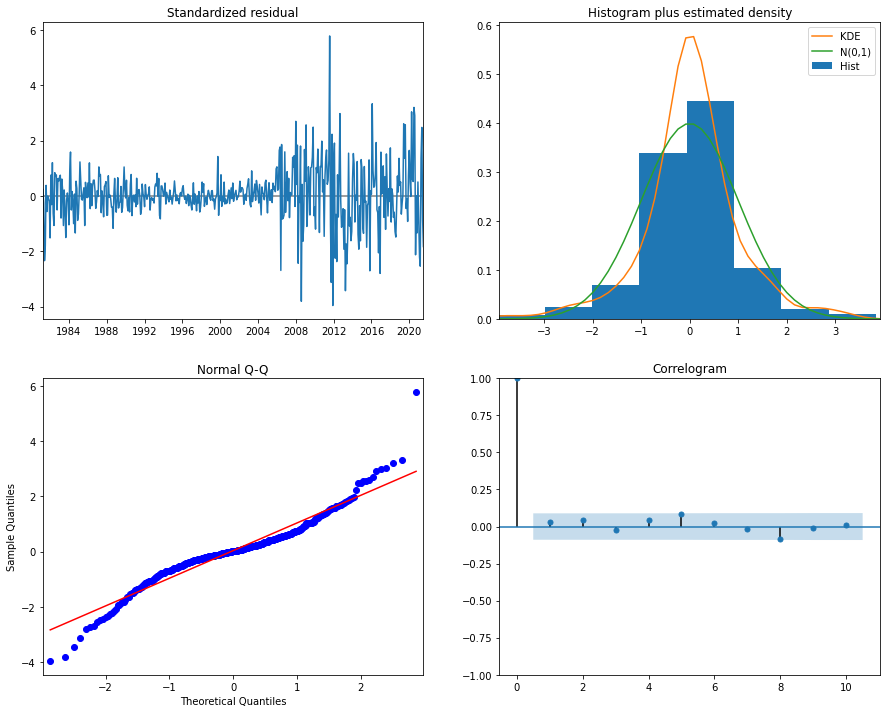

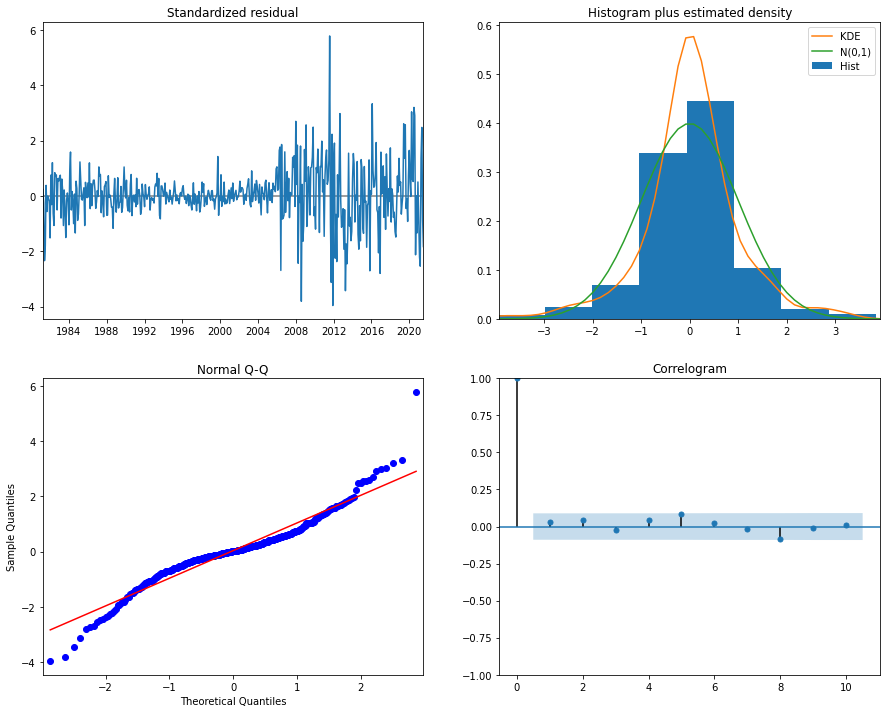

In [ ]:
results.plot_diagnostics(figsize=(15, 12))

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()

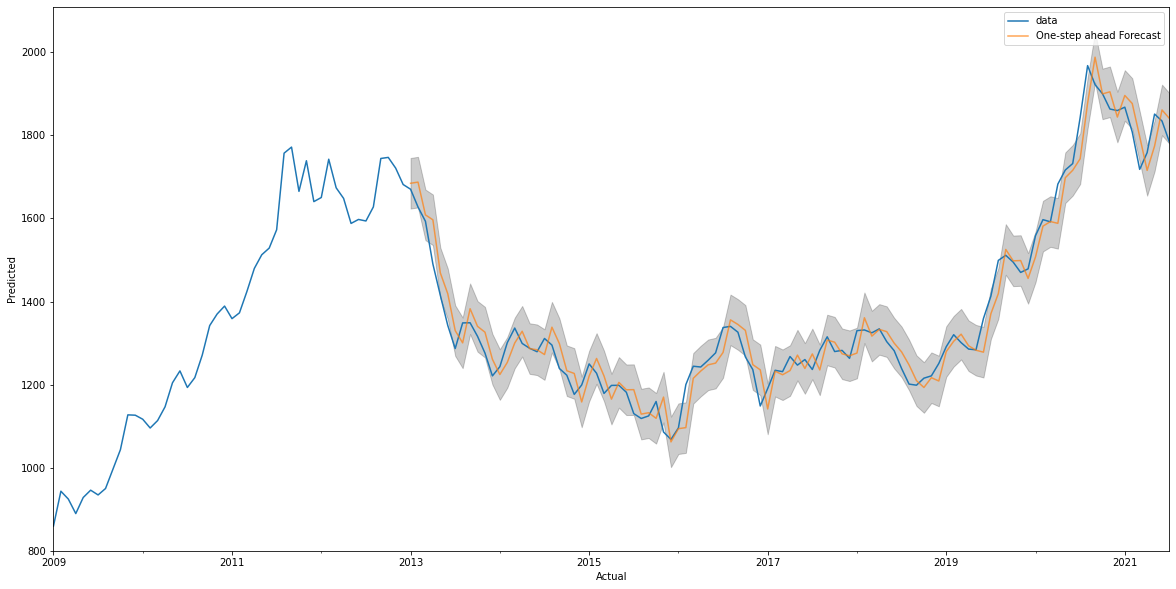

In [ ]:
plt.rcParams['figure.figsize'] = (20,10)
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.legend()


In [ ]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

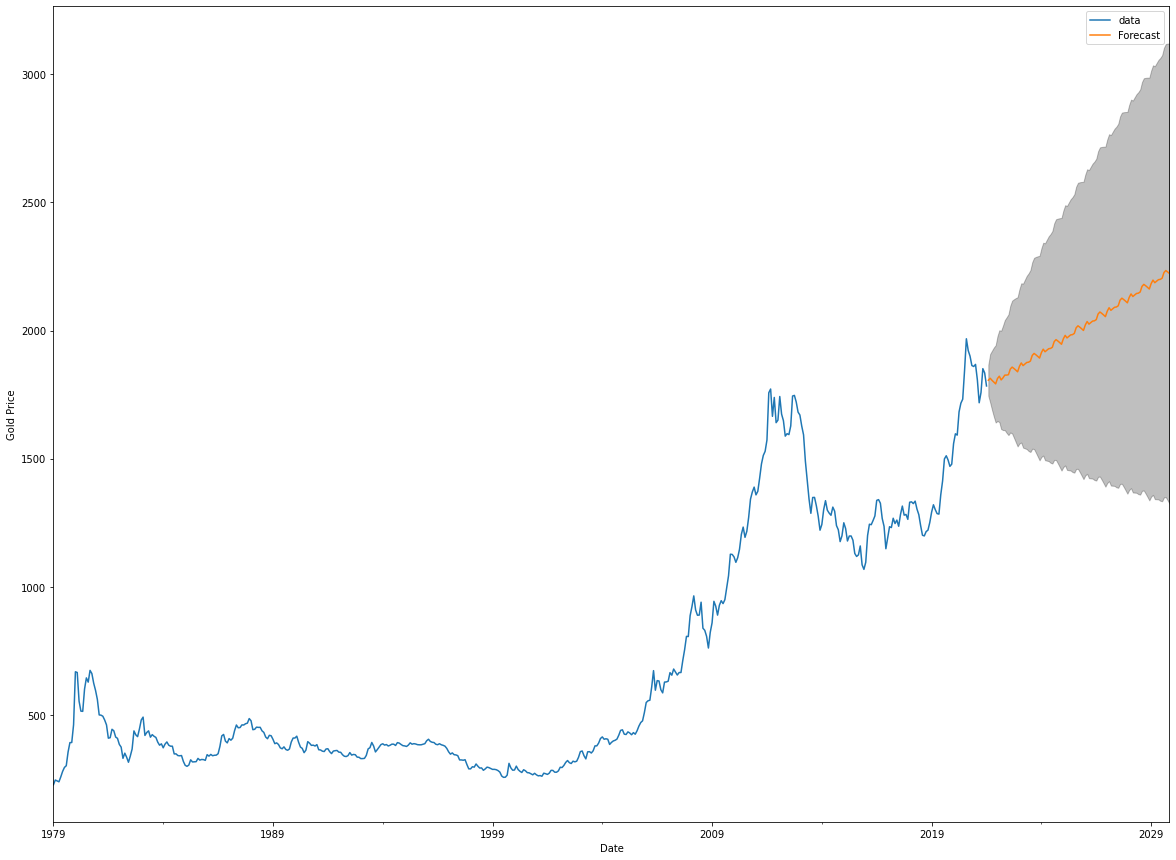

In [ ]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Gold Price')

plt.legend()


## Multivariate forecasting 

In [ ]:
# https://developers.refinitiv.com/en/article-catalog/article/monte-carlo-dropout-for-predicting-prices-with-deep-learning-and-tensorflow

In [ ]:
def get_seq_model(neurons = 16, dr = 0.5, act = "tanh", cell = layers.LSTM):
    inputs = layers.Input(shape = (sequence, X_train.shape[1]))
    x = cell(neurons, activation = act, return_sequences = True)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x, training = True)
    x = cell(neurons, activation = act)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x, training = True)
    x = layers.Dense(neurons // 2, activation = act)(x)
    outputs = layers.Dense(1, activation = "elu")(x)
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    return model
 
def get_conv_model(neurons = 16, k = 5, dr = 0.5, act = "tanh"):
    inputs = layers.Input(shape = (sequence, X_train.shape[1]))
    x = layers.Conv1D(neurons, k, activation = act)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x, training = True)
    x = layers.Conv1D(neurons, k, activation = act)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x, training = True)
    x = layers.Dense(neurons // 2, activation = act)(x)
    outputs = layers.Dense(1, activation = "elu")(x)
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    return model

### Using time encoding as second variatle 

In [ ]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

def make_time_features(series):
    
    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    months = datetimes.month.values
    
    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    
    return hour, dayofw, month

hour, day, month = make_time_features(multivar_df.time)
print("Hours")
print(hour.head())
print("Day of Week")
print(day.head())
print("Months")
print(month.head())

In [ ]:
def split_data(series, train_fraq, test_len=8760):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data


multivar_df = clean_data(multivar_df)

#add hour and month features
hours, day, months = make_time_features(multivar_df.time)
multivar_df = pd.concat([multivar_df.drop(['time'], axis=1), hours, day, months], axis=1)

#scale
multivar_df = min_max_scale(multivar_df)
train_multi, val_multi, test_multi = split_data(multivar_df, train_fraq=0.65, test_len=8760)
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")

### Using additional  feature plus data encoding 

## Model for mutivariate 

In [ ]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

In [ ]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()